# Training Embeddings con GNN
Aca crearemos embeddings paa un grafo de Internet, es decir represenaciones de los SA a partir de la topologia y atributos de los SA.

## Importar Librerias

In [12]:
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
# !pip install scikit-learn
# !pip install matplotlib

In [95]:
%load_ext autoreload
%autoreload 2
# from modules.gnn import GNN
import numpy as np
from modules.gnn import GNN
from modules.gnn_models import GCN, GraphSAGE, GAT
import dgl
import torch
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os
from utils import month_name_to_number
from dgl.nn import DeepWalk
from torch.utils.data import DataLoader
from torch.optim import SparseAdam
from sklearn.metrics import roc_auc_score
from modules.gnn_models import GCNSampler, GraphSAGESample, GATSample
from sklearn.metrics import mean_absolute_error, r2_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
# Path proyecto base
BASE_PROJECT_PATH = os.getcwd() 

# Ruta memoria externa con los datos
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'

# MAximo numero de rutas a procesar del RIB para crear grafo
MAX_NUM_ROUTES = 1000000 # None

# Fecha de ejecucion rutas
MES = "febrero"
ANO = "2024"

## CASO 1: RIBs
Creamos un grafo nx y dgl, ademas de los archivos edges.csv y nodes.csv a partir de archivos ribs previamente creados o de archivo CAIDA AS Relationships.

Crear esos archivos una unica vez con create_graph() una ves ya creados los archivos edges.csv y nodes.csv puedo ocupar directamente la funcion 

Se le puede indicar el maximo de bgp paths que se quiere (hehco para cuando se leen ribs no de caida) 
* Creacion de grafo a partir de paths recolectados de las RIBs por BGPStream.


In [13]:
from modules.graph import create_graphs_from_ribs
# CASO 0,2,3: Grafo con atributos de nodos extraídos de PeeringDB
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "peeringdb")

# CASO 1: Grafo con atributos de grado de entrada y salida 
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "degree")

# CASO 4: Grafo con atributos de nodos generados aleatoriamente 
graph = create_graphs_from_ribs(data_path= DATA_PATH, year= ANO, max_num_routes = MAX_NUM_ROUTES, attr= "random")

[CARPETA CREADA]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/peeringdb/
[ARCHIVO META CREADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/peeringdb//meta.yaml

[CREANDO GRAFO MES]: enero---------------------------------
[SI EXISTE]
numero: 1
graph_id: 1
[NX GRAPH]: DiGraph with 41423 nodes and 148905 edges
[SAVE IN]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/peeringdb/edges.csv
[AGREGANDO TODAS FEATURES A NODOS DESDE PEERINGDB]
Creando archivo: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/peeringdb/nodes.csv
[ARCHIVO ACTUALIZADO]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/peeringdb/nodes.csv
[NX GRAPH]: DiGraph with 41423 nodes and 148905 edges
[GRAFO NX] DiGraph with 41423 nodes and 148905 edges

[CREANDO GRAFO MES]: febrero---------------------------------
[SI EXISTE]
numero: 2
graph_id: 2
[NX GRAPH]: DiGraph with 42242 nodes and 149763 edges
[SAVE IN]: /media/valentina/KINGSTON/TESIS/data/dgl_graph/2024/peeringdb/edges.csv
[AGREGANDO TODA

## Creacion Embeddings con GNNs

Configuraciones

In [9]:
# Ruta archivo CAIDA AS Relationships
# -------------------------------
RELATIONSHIPS_FILE  = DATA_PATH + f"CAIDA_AS_Relationships/Serial_1/{ANO}{month_name_to_number(MES)}01.as-rel.txt.bz2"

# Epochs
# -------------------------------
NUM_EPOCHS = 100

Funciones Auxiliares

In [111]:
def compute_auc(pos_score,neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)


def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_accuracy(pos_score, neg_score, threshold=0.5):

    scores = torch.cat([pos_score, neg_score])

    labels = torch.cat([
        torch.ones(pos_score.shape[0]),
        torch.zeros(neg_score.shape[0])
    ])

    # Convertimos los scores a 1 o 0 según el threshold
    preds = (scores > threshold).float()  # tensor de 0s y 1s

    # Comparar con etiquetas verdaderas
    total_correct = (preds == labels).sum().item()
    acc = total_correct / len(labels)

    print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")
    return acc


def plot_roc_with_distributions(pos_score, neg_score,model_name,caso):
    # Convertir tensores a NumPy
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([
        torch.ones(pos_score.shape[0]),
        torch.zeros(neg_score.shape[0])
    ]).numpy()

    # Calcular ROC y AUC
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)

    # Calcular umbral óptimo (punto más cercano a (0,1))
    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Crear figura con 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Subplot 1: distribuciones de scores
    ax[0].hist(pos_score.numpy(), bins=50, alpha=0.5, label='Puntajes Positivos', color='skyblue')
    ax[0].hist(neg_score.numpy(), bins=50, alpha=0.5, label='Puntajes Negativos', color='salmon')
    ax[0].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Umbral = {optimal_threshold:.2f}')
    ax[0].set_title('Distribuciones de Puntajes Predichos')
    ax[0].set_xlabel('Puntaje')
    ax[0].set_ylabel('Frecuencia')
    ax[0].legend()

    # Subplot 2: curva ROC
    ax[1].plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})', color='blue')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Adivinanza aleatoria')
    ax[1].scatter(optimal_fpr, optimal_tpr, color='red', label=f'Umbral Óptimo = {optimal_threshold:.2f}')
    ax[1].set_xlabel('Tasa de Falsos Positivos')
    ax[1].set_ylabel('Tasa de Verdaderos Positivos')
    ax[1].set_title('Curva ROC')
    ax[1].legend(loc='lower right')
    ax[1].grid(True)


    # Mostrar todo
    plt.tight_layout()
    plt.savefig(DATA_PATH + f'resultados/EnfoquePorPartes/{caso}/roc_curve_{model_name}.png')

    plt.show()

    print(f"AUC: {auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")

    return optimal_threshold


def plot_loss_evolution(losses, num_epochs, title='Evolución del Loss', test_losses=None, figsize=(10, 5)):
    """
    Grafica la evolución del loss durante el entrenamiento y muestra estadísticas.
    
    Parámetros:
    -----------
    losses : list
        Lista de valores de pérdida por época (train loss o loss único)
    num_epochs : int
        Número total de épocas
    title : str, opcional
        Título del gráfico (por defecto 'Evolución del Loss')
    test_losses : list, opcional
        Lista de valores de pérdida de test (si se proporciona, se grafica junto con train)
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto)
    """
    plt.figure(figsize=figsize)
    
    if test_losses is not None:
        # Graficar train y test
        plt.plot(range(1, num_epochs + 1), losses, label='Train', linewidth=2)
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test', linewidth=2)
        plt.legend()
    else:
        # Graficar solo un loss
        plt.plot(range(1, num_epochs + 1), losses, marker='o', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Estadísticas
    print(f"Loss inicial: {losses[0]:.4f}")
    print(f"Loss final: {losses[-1]:.4f}")
    print(f"Reducción: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")
    
    if test_losses is not None:
        print(f"\nTest Loss inicial: {test_losses[0]:.4f}")
        print(f"Test Loss final: {test_losses[-1]:.4f}")


## Creación embeddinsg a partir de la predicción de enlaces en el grafo:

### Caso 0: Predicción de enlaces utilizando grafo con atributos de nodos extraídos de PeeringD

In [ ]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

# CASO 0: Grafo con atributos de nodos extraídos de PeeringDB
# ---------------------------------------
attr = 'mis_attr_febrero'
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'

In [18]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...

gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE, 
                 force_reload=True, 
                 index_graph=index_graph)

gnn.split_edges_link_prediction(0.8)

[LOAD DATASET] Leyendo CSV …
Done saving data into cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({-1: 3325784})
[split_basic] +pos train=2660627  +pos test=665157
[split_basic] -neg train=2660627 -neg test=665157


Encoder: GNN

Decoder: DotProduct

In [24]:
ls /media/valentina/KINGSTON/TESIS/data/resultados/EnfoquePorPartes/caso0/


ls: cannot access '/media/valentina/KINGSTON/TESIS/data/resultados/EnfoquePorPartes/caso0/': No such file or directory


Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.5869835615158081
In epoch 10, loss: 0.527787983417511
In epoch 20, loss: 0.5143570303916931
In epoch 30, loss: 0.5063967704772949
In epoch 40, loss: 0.5010156035423279
In epoch 50, loss: 0.49100399017333984
In epoch 60, loss: 0.4841760993003845
In epoch 70, loss: 0.4789750277996063
In epoch 80, loss: 0.47695600986480713
In epoch 90, loss: 0.47090259194374084
AUC 0.9320877304007792


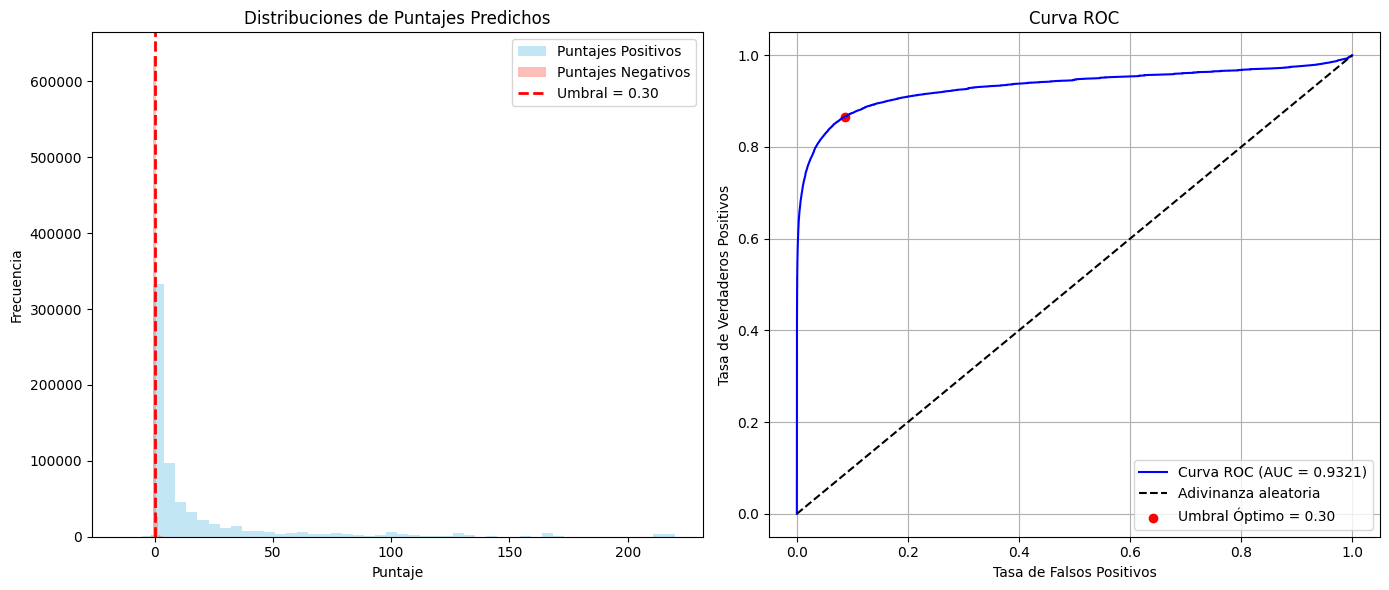

AUC: 0.9321
Optimal Threshold: 0.2981
Accuracy: 0.8900 (Threshold: 0.30)
Accuracy: 0.8900 (Threshold: 0.30)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 7.672895908355713
In epoch 10, loss: 2.1708006858825684
In epoch 20, loss: 1.478043556213379
In epoch 30, loss: 1.1498379707336426
In epoch 40, loss: 1.0092965364456177
In epoch 50, loss: 0.9389904141426086
In epoch 60, loss: 0.8652335405349731
In epoch 70, loss: 0.7886828780174255
In epoch 80, loss: 0.7476631999015808
In epoch 90, loss: 0.7046733498573303
AUC 0.8162830368997782


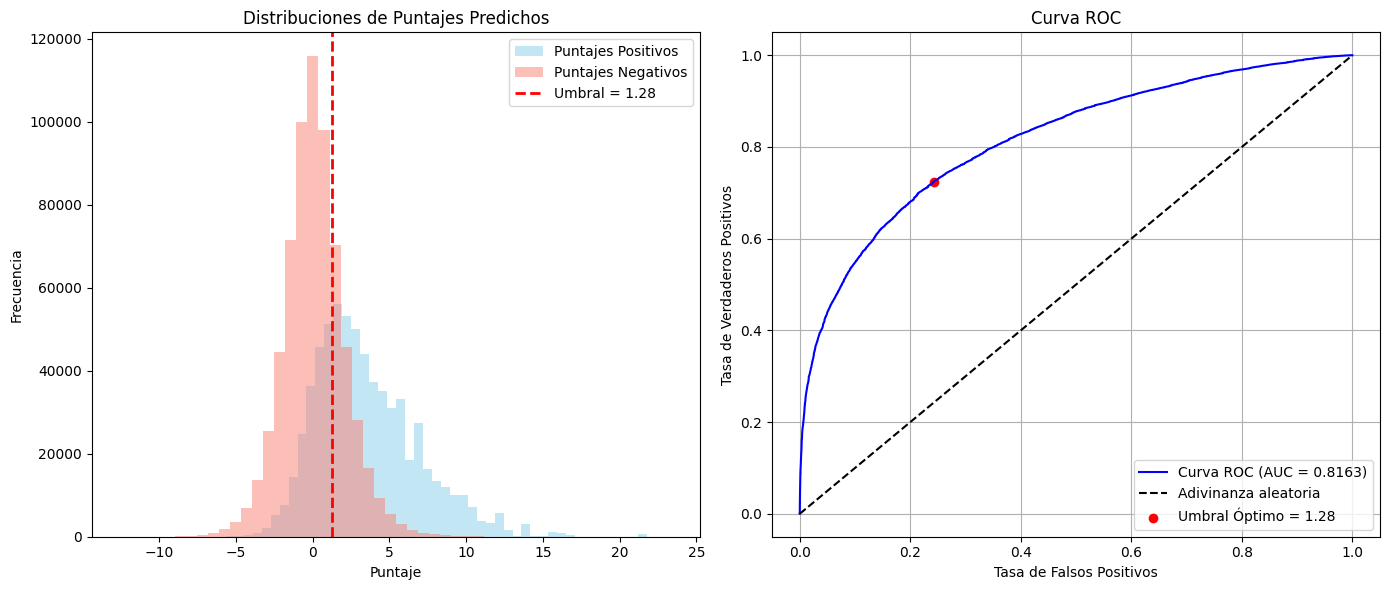

AUC: 0.8163
Optimal Threshold: 1.2818
Accuracy: 0.7410 (Threshold: 1.28)
Accuracy: 0.7410 (Threshold: 1.28)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 3.610039234161377
In epoch 10, loss: 1.192357063293457
In epoch 20, loss: 0.7658703327178955
In epoch 30, loss: 0.6929522752761841
In epoch 40, loss: 0.6818429231643677
In epoch 50, loss: 0.6572346091270447
In epoch 60, loss: 0.6240983605384827
In epoch 70, loss: 0.6090136766433716
In epoch 80, loss: 0.5888246297836304
In epoch 90, loss: 0.5683256387710571
AUC 0.8254385490572368


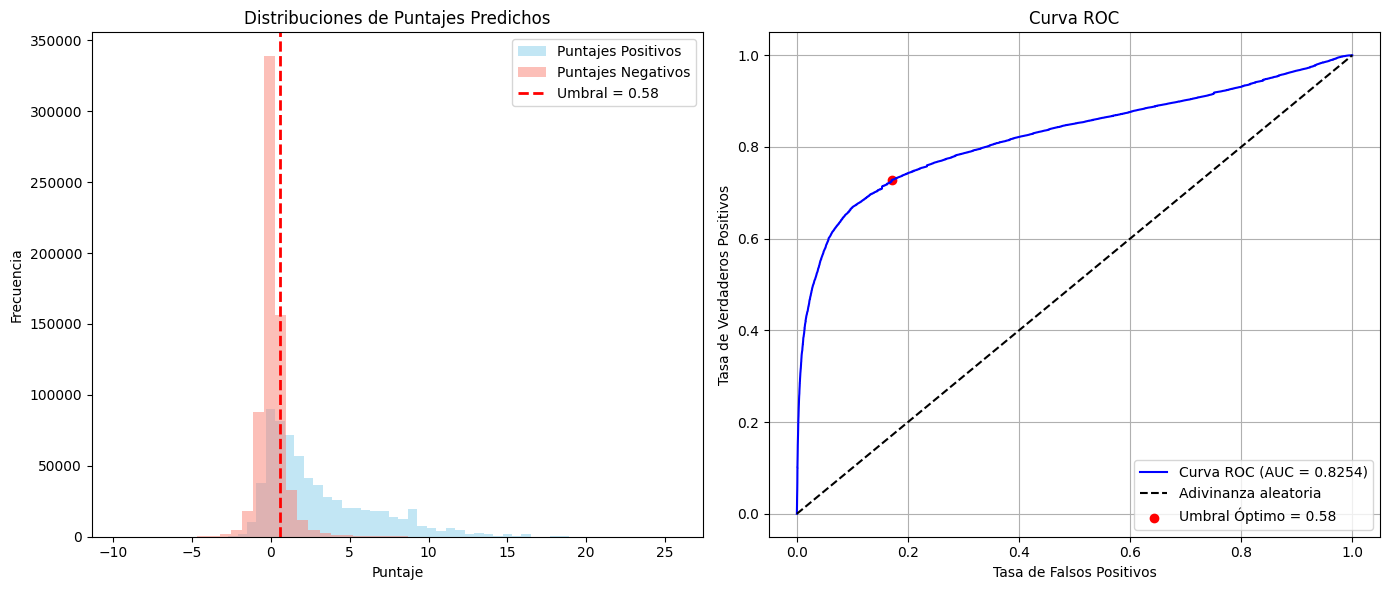

AUC: 0.8254
Optimal Threshold: 0.5754
Accuracy: 0.7785 (Threshold: 0.58)
Accuracy: 0.7785 (Threshold: 0.58)


In [ ]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

for model_name in models:
    # 1.- Entrenamiento de cada modelo
    # -----------------------------------

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 2.- Entrenamiento
    # -------------------------------- 

    train_losses = []
    test_losses = []
    
    for e in range(NUM_EPOCHS):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)

        loss = compute_loss(pos_score, neg_score)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluar en test set
        model.eval()
        with torch.no_grad():
            h_eval = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
            pos_score_test = model.decodeDotProduct(gnn.test_pos_g, h_eval)
            neg_score_test = model.decodeDotProduct(gnn.test_neg_g, h_eval)
            test_loss = compute_loss(pos_score_test, neg_score_test)
            test_losses.append(test_loss.item())

        if e % 10 == 0:
            print("In epoch {}, train loss: {:.6f}, test loss: {:.6f}".format(e, loss.item(), test_loss.item()))
    
    # Visualizar evolución del loss
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (DotProduct): Evolución del Loss',
                       test_losses=test_losses)
    
    # 3.- Check de resultados 
    # --------------------------
    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h_eval)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h_eval)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr,"Caso0") 
        acc = compute_accuracy(pos_score, neg_score, threshold=threshold)
        print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")

    # 4.- Guardar modelo 
    # --------------------------
    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso0' + f'/model_emb_{decoder}_{model_name}_{attr}.pth')

    # 5.- Guardar embeddings
    # ------------------------
    torch.save(h_eval, DATA_PATH + 'resultados/EnfoquePorPartes/Caso0'  + f"/embeddings_ribs_{decoder}_{model_name}_{attr}.pt")

Encoder: GNN

Decoder: MLP

Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.6808146834373474
In epoch 10, loss: 0.4656716585159302
In epoch 20, loss: 0.3536228835582733
In epoch 30, loss: 0.26480376720428467
In epoch 40, loss: 0.2396605908870697
In epoch 50, loss: 0.22105872631072998
In epoch 60, loss: 0.21173983812332153
In epoch 70, loss: 0.20074284076690674
In epoch 80, loss: 0.19628526270389557
In epoch 90, loss: 0.19280588626861572
AUC 0.9797257189391578


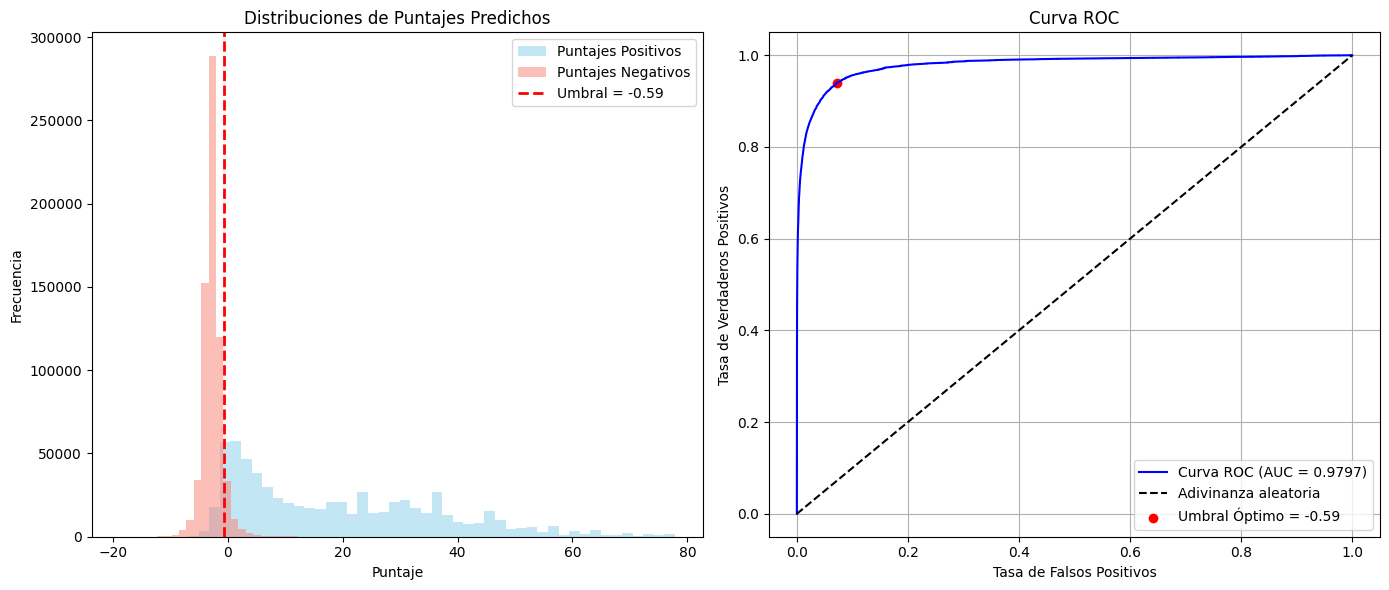

AUC: 0.9797
Optimal Threshold: -0.5929
Accuracy: 0.9336 (Threshold: -0.59)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 0.6923492550849915
In epoch 10, loss: 0.3163251280784607
In epoch 20, loss: 0.20064513385295868
In epoch 30, loss: 0.17603161931037903
In epoch 40, loss: 0.15937282145023346
In epoch 50, loss: 0.1447778344154358
In epoch 60, loss: 0.13896021246910095
In epoch 70, loss: 0.12883000075817108
In epoch 80, loss: 0.12140216678380966
In epoch 90, loss: 0.11314824968576431
AUC 0.9922881925040683


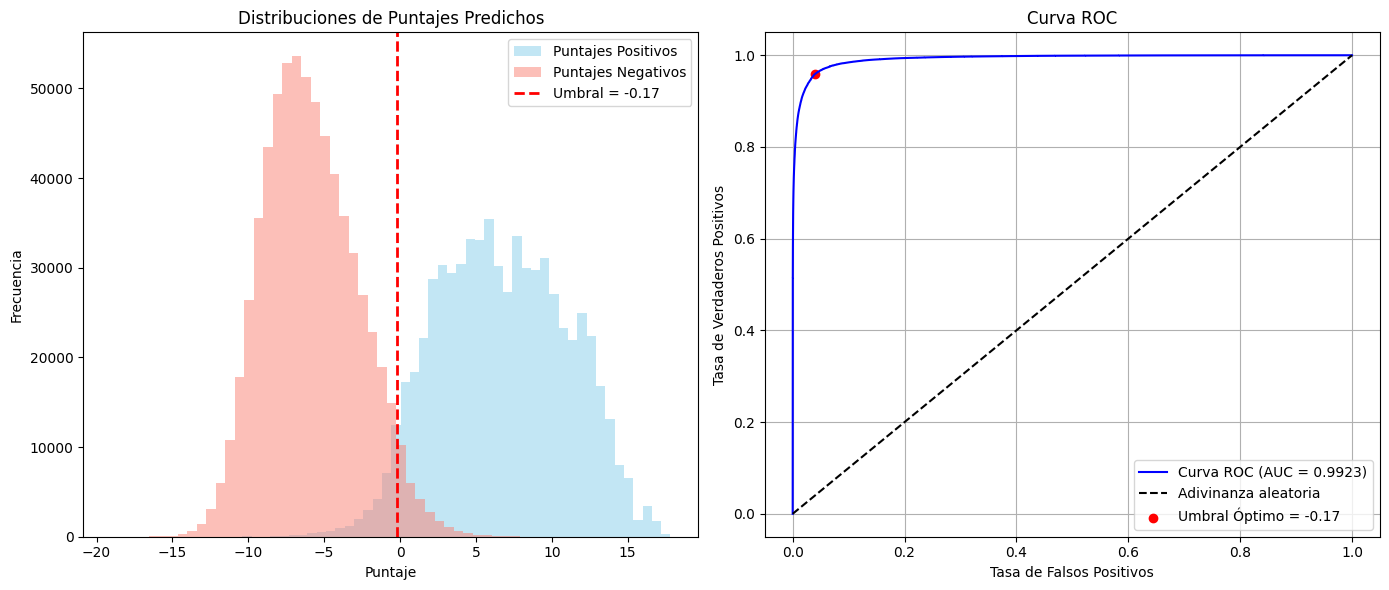

AUC: 0.9923
Optimal Threshold: -0.1697
Accuracy: 0.9596 (Threshold: -0.17)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 0.7095617055892944
In epoch 10, loss: 0.5936287045478821
In epoch 20, loss: 0.4118039608001709
In epoch 30, loss: 0.30926600098609924
In epoch 40, loss: 0.2993554174900055
In epoch 50, loss: 0.2762450873851776
In epoch 60, loss: 0.2642044126987457
In epoch 70, loss: 0.2579455077648163
In epoch 80, loss: 0.2425689995288849
In epoch 90, loss: 0.23381434381008148
AUC 0.9661217151229149


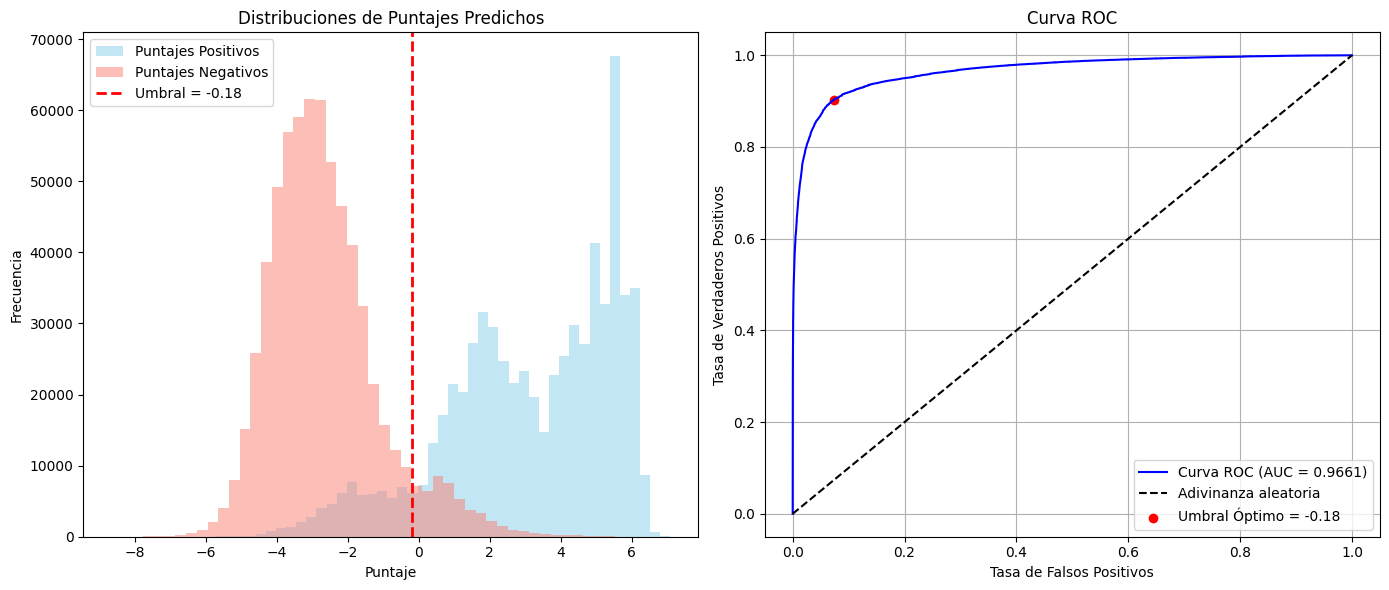

AUC: 0.9661
Optimal Threshold: -0.1782
Accuracy: 0.9150 (Threshold: -0.18)


In [ ]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 32 
out_feats = 16

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # ----------- training -------------------------------- #

    train_losses = []
    test_losses = []
    
    for e in range(NUM_EPOCHS):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeMLP(gnn.train_pos_g, h)
        neg_score = model.decodeMLP(gnn.train_neg_g, h)

        loss = compute_loss(pos_score, neg_score)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluar en test set
        model.eval()
        with torch.no_grad():
            h_eval = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
            pos_score_test = model.decodeMLP(gnn.test_pos_g, h_eval)
            neg_score_test = model.decodeMLP(gnn.test_neg_g, h_eval)
            test_loss = compute_loss(pos_score_test, neg_score_test)
            test_losses.append(test_loss.item())

        if e % 10 == 0:
            print("In epoch {}, train loss: {:.6f}, test loss: {:.6f}".format(e, loss.item(), test_loss.item()))

    # Visualizar evolución del loss
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (MLP): Evolución del Loss',
                       test_losses=test_losses)

    # 3.- Check de resultados 
    # --------------------------
    with torch.no_grad():
        pos_score = model.decodeMLP(gnn.test_pos_g, h_eval)
        neg_score = model.decodeMLP(gnn.test_neg_g, h_eval)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr,"Caso0")
        compute_accuracy(pos_score, neg_score, threshold=threshold)

    # 4.- Guardar modelo 
    # --------------------------
    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso0' + f'/model_emb_{decoder}_{model_name}_{attr}.pth')

    # 5.- Guardar embeddings
    # ------------------------
    torch.save(h_eval, DATA_PATH + 'resultados/EnfoquePorPartes/Caso0'  + f"/embeddings_ribs_{decoder}_{model_name}_{attr}.pt") 

### Caso 1: Predicción de enlaces utilizando grafo con atributos de grado de entrada y salida

In [21]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

# CASO 1: Grafo con atributos de grado de entrada y salida:
# ---------------------------------------
attr = 'grado_attr_febrero' 
INTERNETGRAPH_FILE = DATA_PATH + '/dgl_graph/2024/degree'

In [22]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...

gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE, 
                 force_reload=True, 
                 index_graph=index_graph) 

gnn.split_edges_link_prediction(0.8)

[LOAD DATASET] Leyendo CSV …
Done saving data into cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({-1: 3325784})
[split_basic] +pos train=2660627  +pos test=665157
[split_basic] -neg train=2660627 -neg test=665157


Encoder: GNN

Decoder: DotProduct

Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.6523011326789856
In epoch 10, loss: 0.6096482872962952
In epoch 20, loss: 0.56964510679245
In epoch 30, loss: 0.5417740941047668
In epoch 40, loss: 0.5344796776771545
In epoch 50, loss: 0.530418336391449
In epoch 60, loss: 0.5219576954841614
In epoch 70, loss: 0.5176736116409302
In epoch 80, loss: 0.5114011168479919
In epoch 90, loss: 0.5026177763938904
AUC 0.9608360687112762


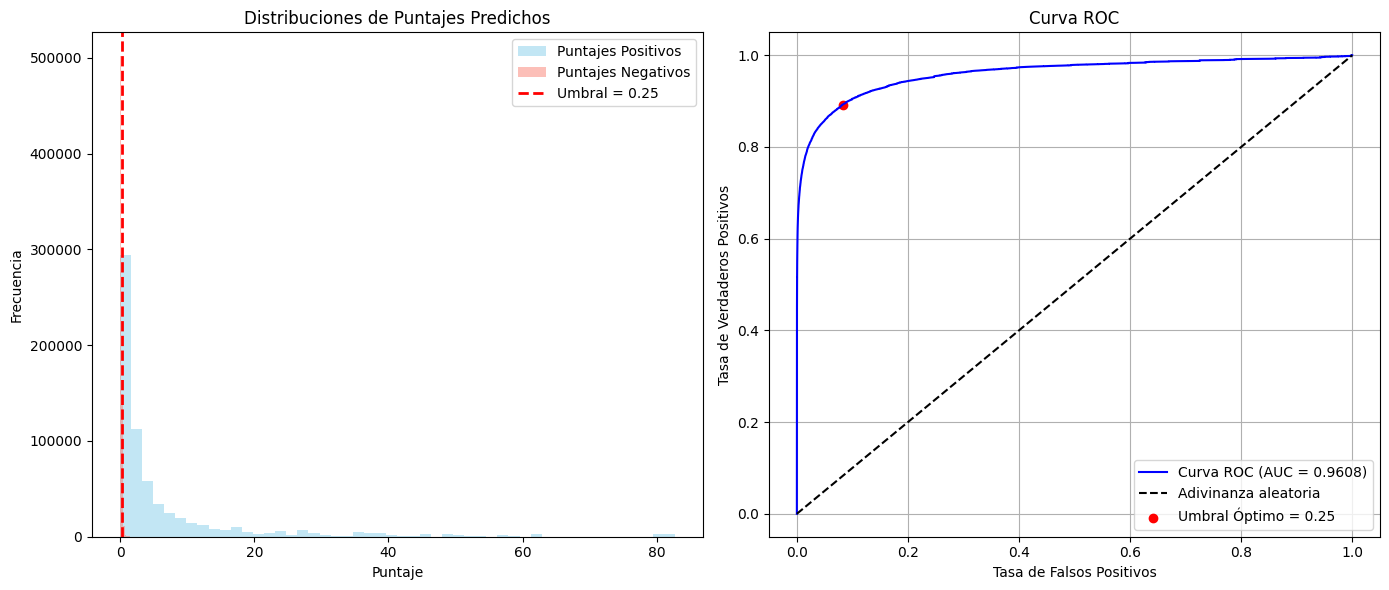

AUC: 0.9608
Optimal Threshold: 0.2542
Accuracy: 0.9050 (Threshold: 0.25)
Accuracy: 0.9050 (Threshold: 0.25)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 9.523199081420898
In epoch 10, loss: 4.554117679595947
In epoch 20, loss: 1.8599164485931396
In epoch 30, loss: 1.0890666246414185
In epoch 40, loss: 0.9114192724227905
In epoch 50, loss: 0.8095741271972656
In epoch 60, loss: 0.7284420728683472
In epoch 70, loss: 0.7506891489028931
In epoch 80, loss: 0.7288782596588135
In epoch 90, loss: 0.6979668736457825
AUC 0.7919277144738867


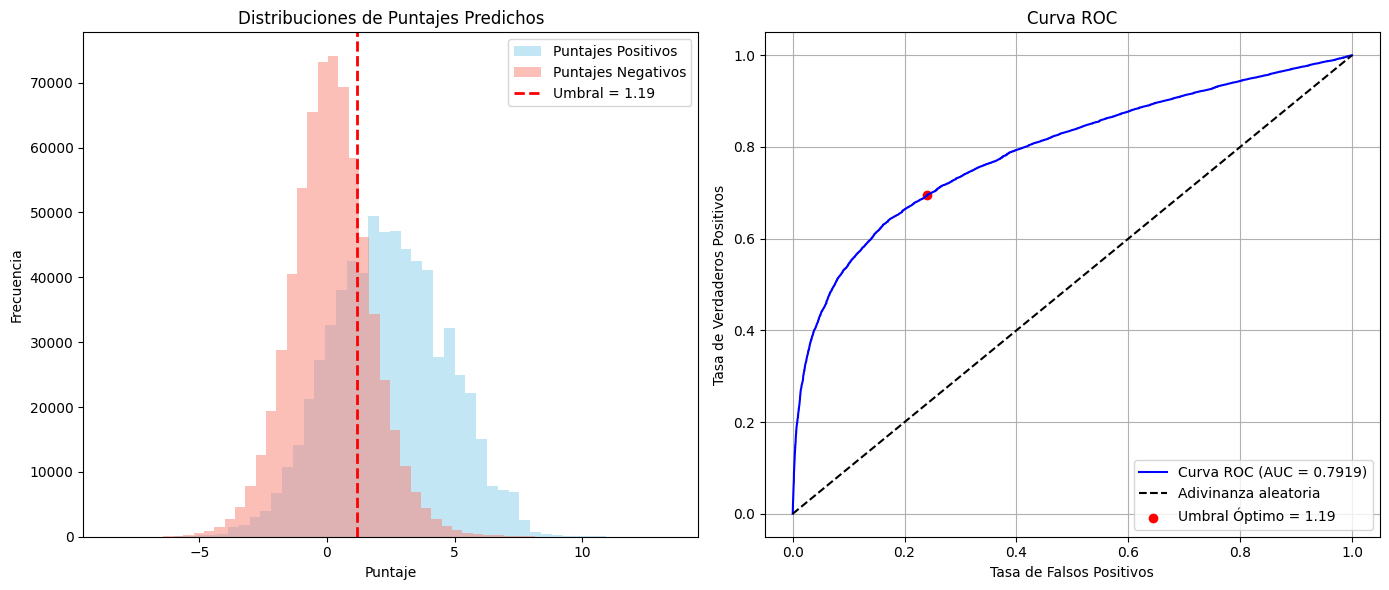

AUC: 0.7919
Optimal Threshold: 1.1884
Accuracy: 0.7274 (Threshold: 1.19)
Accuracy: 0.7274 (Threshold: 1.19)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 1.129544973373413
In epoch 10, loss: 0.84196937084198
In epoch 20, loss: 0.7556019425392151
In epoch 30, loss: 0.7253891825675964
In epoch 40, loss: 0.7075645327568054
In epoch 50, loss: 0.7053956389427185
In epoch 60, loss: 0.699151337146759
In epoch 70, loss: 0.6953115463256836
In epoch 80, loss: 0.6933460831642151
In epoch 90, loss: 0.6921389698982239
AUC 0.5115818025107985


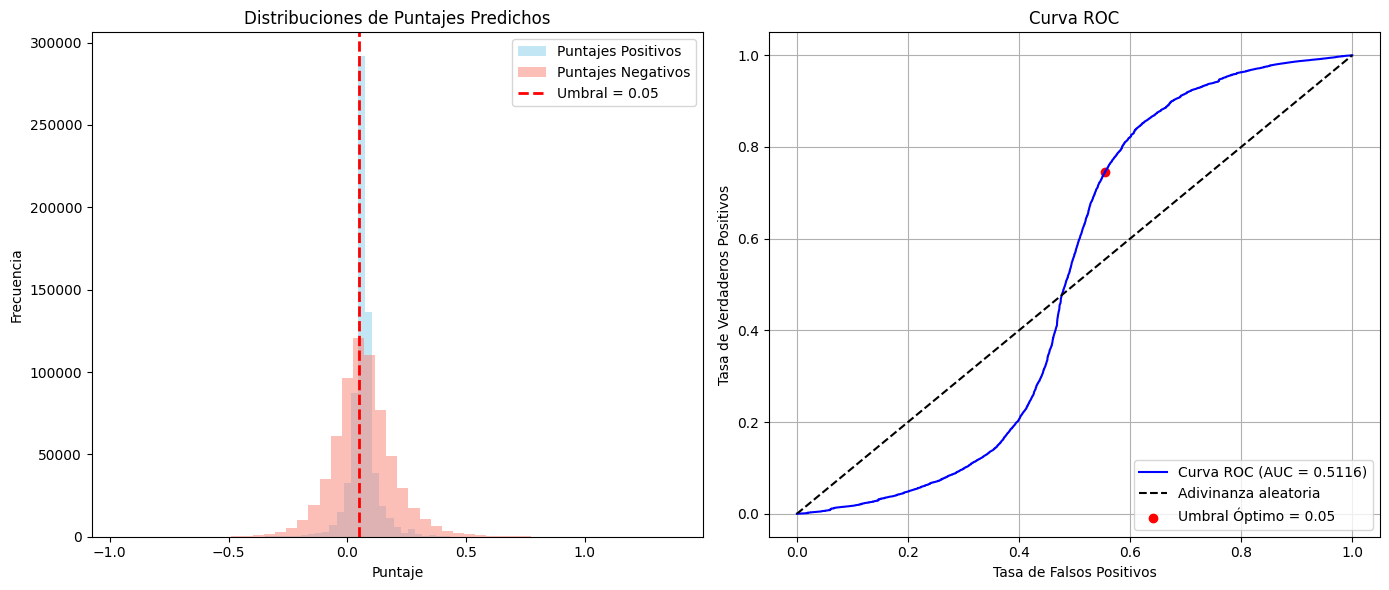

AUC: 0.5116
Optimal Threshold: 0.0488
Accuracy: 0.5952 (Threshold: 0.05)
Accuracy: 0.5952 (Threshold: 0.05)


In [ ]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 2.- Entrenamiento
    # -------------------------------- 
    train_losses = []
    test_losses = []
    
    for e in range(NUM_EPOCHS):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)

        loss = compute_loss(pos_score, neg_score)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluar en test set
        model.eval()
        with torch.no_grad():
            h_eval = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
            pos_score_test = model.decodeDotProduct(gnn.test_pos_g, h_eval)
            neg_score_test = model.decodeDotProduct(gnn.test_neg_g, h_eval)
            test_loss = compute_loss(pos_score_test, neg_score_test)
            test_losses.append(test_loss.item())

        if e % 10 == 0:
            print("In epoch {}, train loss: {:.6f}, test loss: {:.6f}".format(e, loss.item(), test_loss.item()))
    
    # Visualizar evolución del loss
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (DotProduct): Evolución del Loss',
                       test_losses=test_losses)
    
    # 3.- Check de resultados 
    # --------------------------
    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h_eval)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h_eval)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr, "Caso1") 
        acc = compute_accuracy(pos_score, neg_score, threshold=threshold)
        print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")


    # 4.- Guardar modelo 
    # --------------------------
    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso1' + f'/model_emb_{decoder}_{model_name}_{attr}.pth')

    # 5.- Guardar embeddings
    # ------------------------
    torch.save(h_eval, DATA_PATH + 'resultados/EnfoquePorPartes/Caso1'  + f"/embeddings_ribs_{decoder}_{model_name}_{attr}.pt")


Encoder: GNN

Decoder: MLP

Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.6541591286659241
In epoch 5, loss: 0.630336582660675
In epoch 10, loss: 0.6102803945541382
In epoch 15, loss: 0.5900099873542786
In epoch 20, loss: 0.5669462084770203
In epoch 25, loss: 0.5575870275497437
In epoch 30, loss: 0.5414646863937378
In epoch 35, loss: 0.5348326563835144
In epoch 40, loss: 0.5333933234214783
In epoch 45, loss: 0.532794177532196
In epoch 50, loss: 0.5269660353660583
In epoch 55, loss: 0.5234190225601196
In epoch 60, loss: 0.522895872592926
In epoch 65, loss: 0.517920732498169
In epoch 70, loss: 0.5116207599639893
In epoch 75, loss: 0.5130952000617981
In epoch 80, loss: 0.5060656070709229
In epoch 85, loss: 0.5085468888282776
In epoch 90, loss: 0.5061807632446289
In epoch 95, loss: 0.5027167201042175
AUC 0.9578849171056676


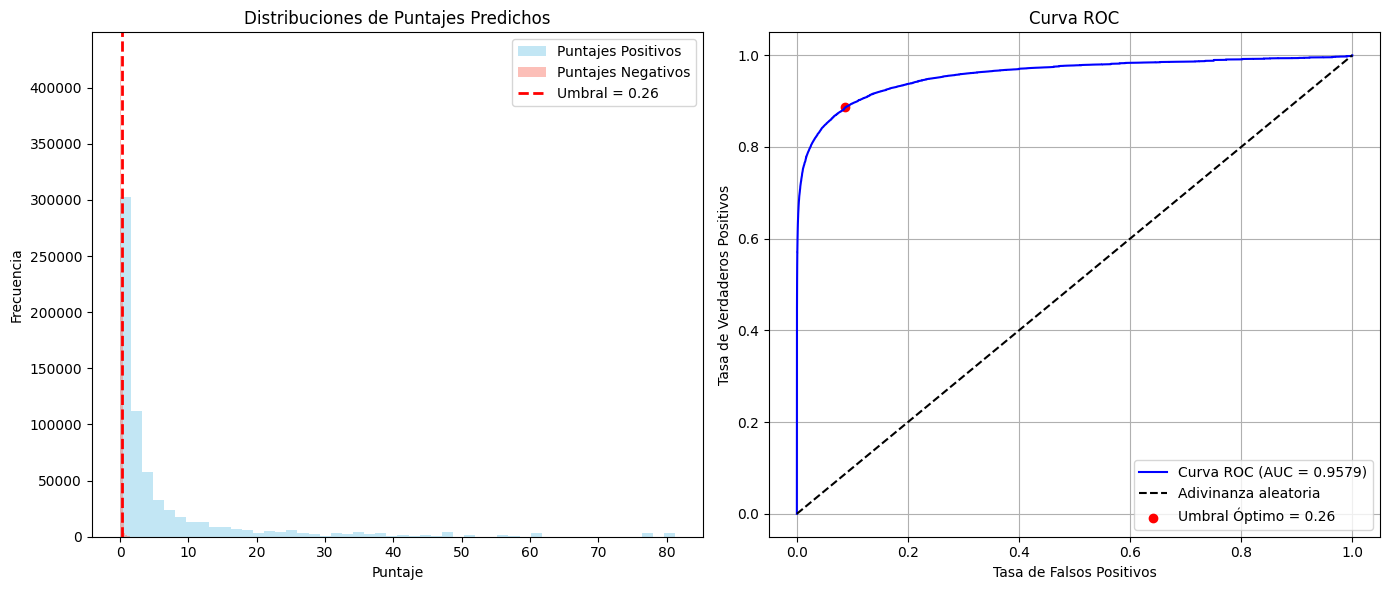

AUC: 0.9579
Optimal Threshold: 0.2571
Accuracy: 0.8995 (Threshold: 0.26)
Accuracy: 0.8995 (Threshold: 0.26)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 12.90694522857666
In epoch 5, loss: 9.08464241027832
In epoch 10, loss: 6.680735111236572
In epoch 15, loss: 4.45233154296875
In epoch 20, loss: 3.2273671627044678
In epoch 25, loss: 2.277266025543213
In epoch 30, loss: 1.7853758335113525
In epoch 35, loss: 1.37544584274292
In epoch 40, loss: 1.1658565998077393
In epoch 45, loss: 1.0704816579818726
In epoch 50, loss: 0.9742243885993958
In epoch 55, loss: 0.9122412800788879
In epoch 60, loss: 0.9077775478363037
In epoch 65, loss: 0.8678997755050659
In epoch 70, loss: 0.8651562929153442
In epoch 75, loss: 0.8555669188499451
In epoch 80, loss: 0.8419962525367737
In epoch 85, loss: 0.8124432563781738
In epoch 90, loss: 0.8043248057365417
In epoch 95, loss: 0.7526852488517761
AUC 0.7784145193749107


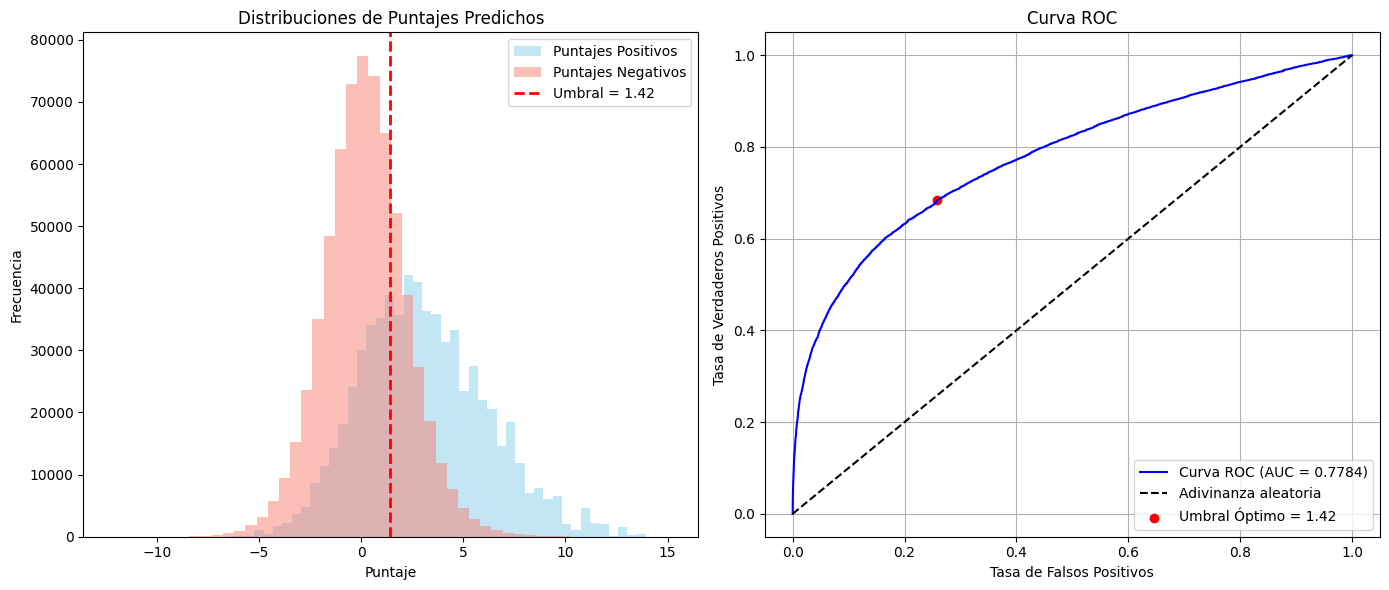

AUC: 0.7784
Optimal Threshold: 1.4247
Accuracy: 0.7130 (Threshold: 1.42)
Accuracy: 0.7130 (Threshold: 1.42)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 0.8075202107429504
In epoch 5, loss: 0.7496167421340942
In epoch 10, loss: 0.7207822203636169
In epoch 15, loss: 0.7091276049613953
In epoch 20, loss: 0.7013857364654541
In epoch 25, loss: 0.6961753964424133
In epoch 30, loss: 0.6949242353439331
In epoch 35, loss: 0.6960245370864868
In epoch 40, loss: 0.6947532296180725
In epoch 45, loss: 0.6943546533584595
In epoch 50, loss: 0.6915032267570496
In epoch 55, loss: 0.6937011480331421
In epoch 60, loss: 0.6930825114250183
In epoch 65, loss: 0.6945065259933472
In epoch 70, loss: 0.6918325424194336
In epoch 75, loss: 0.6895349025726318
In epoch 80, loss: 0.6917555332183838
In epoch 85, loss: 0.6914390325546265
In epoch 90, loss: 0.693423867225647
In epoch 95, loss: 0.6909375786781311
AUC 0.5582882567151746


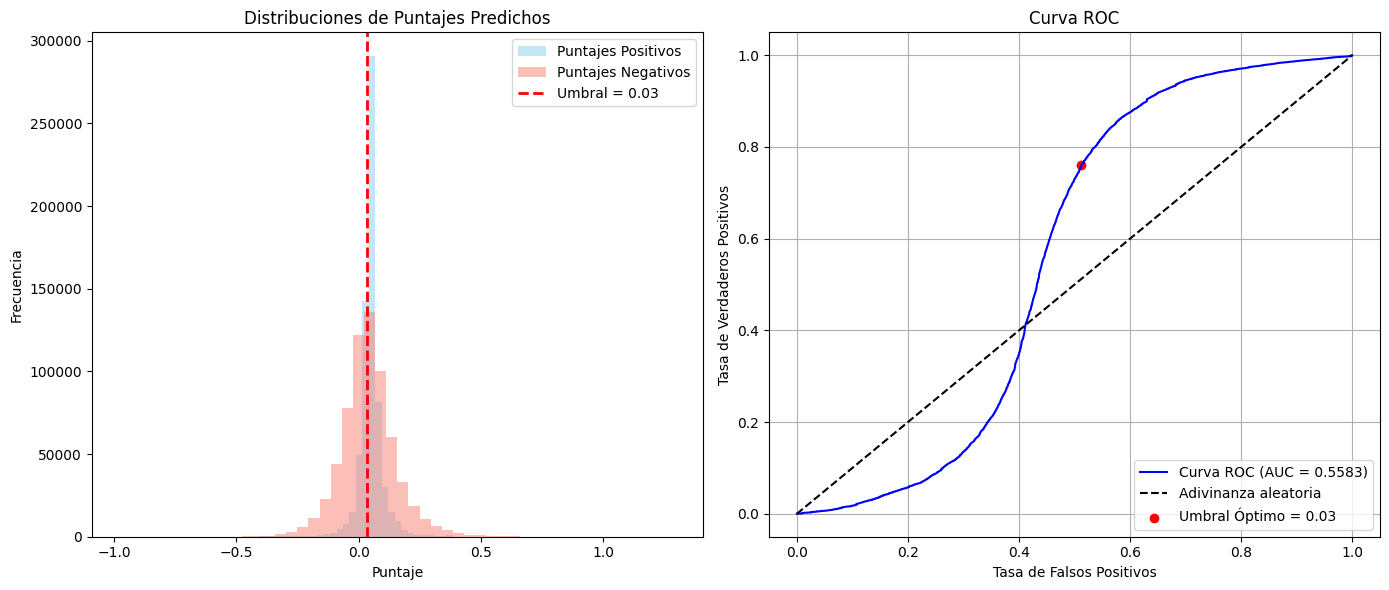

AUC: 0.5583
Optimal Threshold: 0.0327
Accuracy: 0.6241 (Threshold: 0.03)
Accuracy: 0.6241 (Threshold: 0.03)


In [ ]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 2.- Entrenamiento
    # --------------------------
    train_losses = []
    test_losses = []
    
    for e in range(NUM_EPOCHS):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata['feat'])
        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluar en test set
        model.eval()
        with torch.no_grad():
            h_eval = model.encode(gnn.train_g, gnn.train_g.ndata['feat'])
            pos_score_test = model.decodeDotProduct(gnn.test_pos_g, h_eval)
            neg_score_test = model.decodeDotProduct(gnn.test_neg_g, h_eval)
            test_loss = compute_loss(pos_score_test, neg_score_test)
            test_losses.append(test_loss.item())

        if e % 10 == 0:
            print('In epoch {}, train loss: {:.6f}, test loss: {:.6f}'.format(e, loss.item(), test_loss.item()))

    # Visualizar evolución del loss
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (DotProduct): Evolución del Loss',
                       test_losses=test_losses)

    # 3.- Check de resultados 
    # --------------------------
    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h_eval)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h_eval)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr, "Caso1") 
        acc = compute_accuracy(pos_score, neg_score, threshold=threshold)
        print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")

    # 4.- Guardar modelo 
    # --------------------------
    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso1' + f'/model_emb_{decoder}_{model_name}_{attr}.pth')

    # 5.- Guardar embeddings
    # ------------------------
    torch.save(h_eval, DATA_PATH + 'resultados/EnfoquePorPartes/Caso1'  + f"/embeddings_ribs_{decoder}_{model_name}_{attr}.pt")

### Caso 2: Predicciónde enlaces utilizando grafo con atributos provenientes de estudios previos

In [28]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

# CASO 2: Grafo Paper con atributos de nodos creados previamente
# ---------------------------------------
attr = '2022_attr' 
INTERNETGRAPH_FILE = '/media/valentina/KINGSTON/TESIS/InternetGNNData2022'

In [29]:
index_graph = 0  # Solo hay un grafo en este dataset

gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE, 
                 force_reload=True, 
                 index_graph=index_graph) 

gnn.split_edges_link_prediction(0.8)

[LOAD DATASET] Leyendo CSV …
Done saving data into cached files.
[LOAD DATASET] Grafo Graph(num_nodes=46235, num_edges=433979,
      ndata_schemes={'feat': Scheme(shape=(72,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({-1: 433979})
[split_basic] +pos train=347183  +pos test=86796
[split_basic] -neg train=347183 -neg test=86796


Encoder: GNN

Decoder: DotProduct

Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.6722086071968079
In epoch 10, loss: 0.6507795453071594
In epoch 20, loss: 0.6312767863273621
In epoch 30, loss: 0.6111083626747131
In epoch 40, loss: 0.5881714820861816
In epoch 50, loss: 0.5649293065071106
In epoch 60, loss: 0.5426180362701416
In epoch 70, loss: 0.5267466306686401
In epoch 80, loss: 0.515412449836731
In epoch 90, loss: 0.5072372555732727
AUC 0.8599090406038632


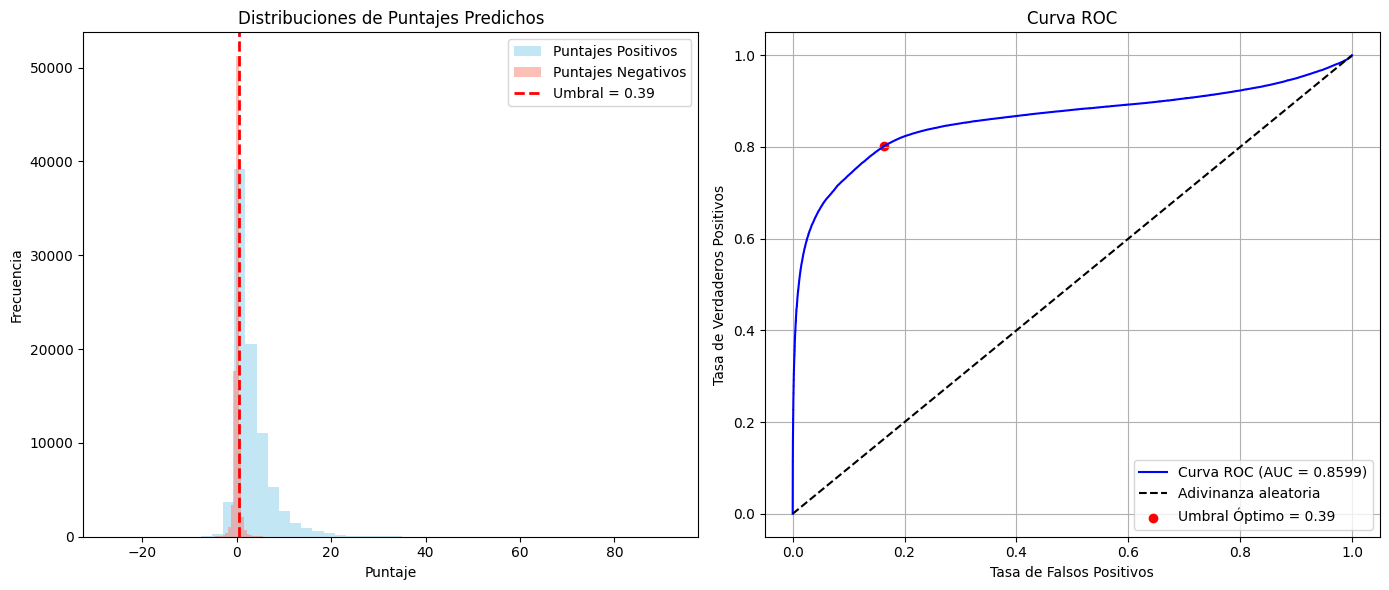

AUC: 0.8599
Optimal Threshold: 0.3884
Accuracy: 0.8194 (Threshold: 0.39)
Accuracy: 0.8194 (Threshold: 0.39)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 8.46377944946289
In epoch 10, loss: 1.8513721227645874
In epoch 20, loss: 0.9663931727409363
In epoch 30, loss: 0.8565921783447266
In epoch 40, loss: 0.7563129663467407
In epoch 50, loss: 0.7073305249214172
In epoch 60, loss: 0.6769999265670776
In epoch 70, loss: 0.6533639430999756
In epoch 80, loss: 0.6443310976028442
In epoch 90, loss: 0.6138510704040527
AUC 0.797428573106552


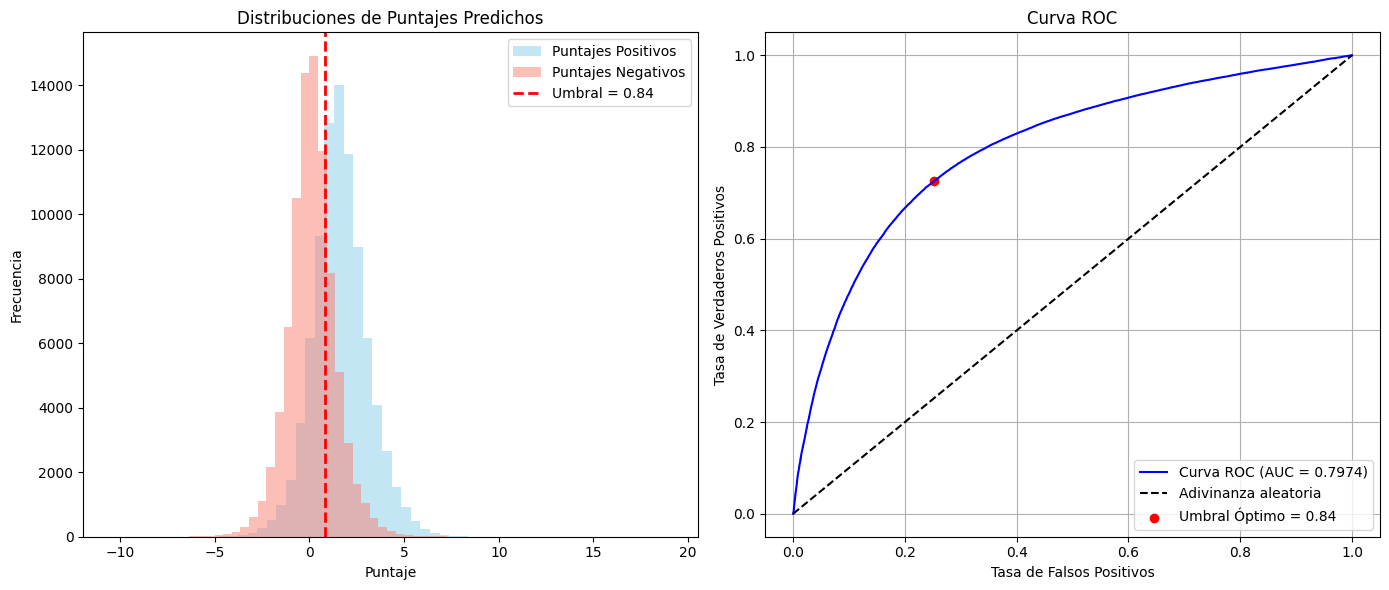

AUC: 0.7974
Optimal Threshold: 0.8435
Accuracy: 0.7369 (Threshold: 0.84)
Accuracy: 0.7369 (Threshold: 0.84)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 3.895007371902466
In epoch 10, loss: 1.250523328781128
In epoch 20, loss: 0.7344732880592346
In epoch 30, loss: 0.6965793967247009
In epoch 40, loss: 0.6797164082527161
In epoch 50, loss: 0.6600802540779114
In epoch 60, loss: 0.6472460031509399
In epoch 70, loss: 0.636845588684082
In epoch 80, loss: 0.6063471436500549
In epoch 90, loss: 0.5950028300285339
AUC 0.8396792063706541


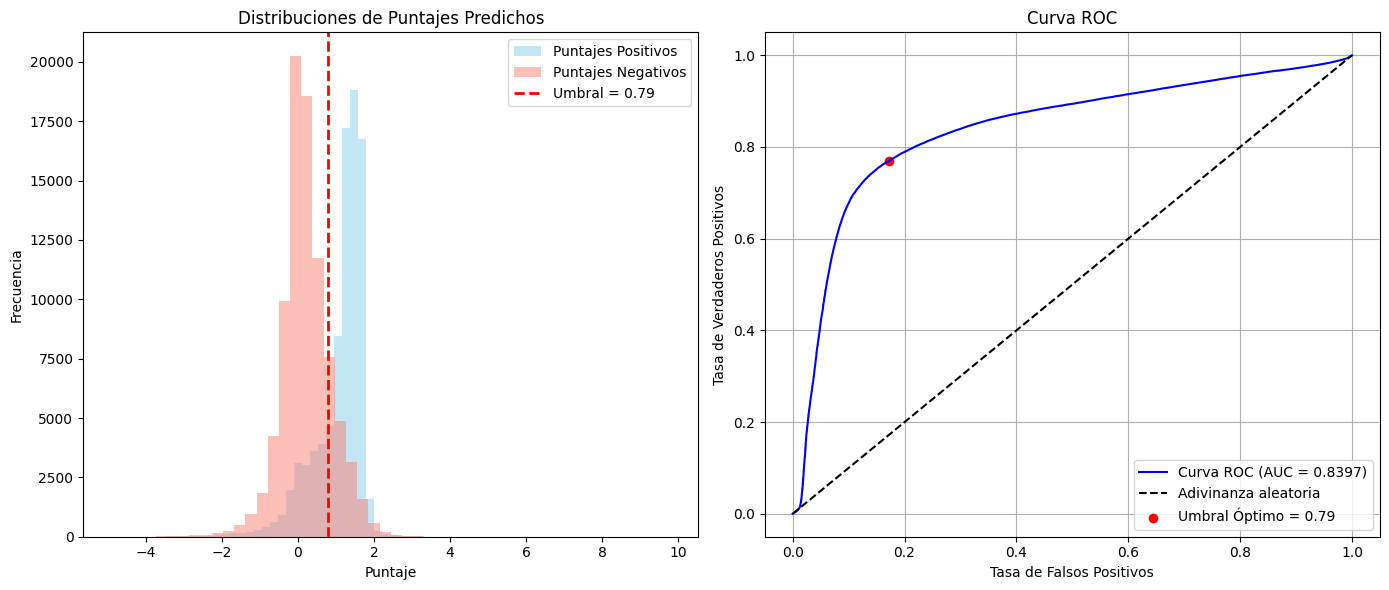

AUC: 0.8397
Optimal Threshold: 0.7891
Accuracy: 0.7989 (Threshold: 0.79)
Accuracy: 0.7989 (Threshold: 0.79)


In [ ]:
decoder = 'DotProduct'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 2.- Entrenamiento
    # -------------------------------- 
    train_losses = []
    test_losses = []
    
    for e in range(NUM_EPOCHS):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])

        pos_score = model.decodeDotProduct(gnn.train_pos_g, h)
        neg_score = model.decodeDotProduct(gnn.train_neg_g, h)

        loss = compute_loss(pos_score, neg_score)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluar en test set
        model.eval()
        with torch.no_grad():
            h_eval = model.encode(gnn.train_g, gnn.train_g.ndata["feat"])
            pos_score_test = model.decodeDotProduct(gnn.test_pos_g, h_eval)
            neg_score_test = model.decodeDotProduct(gnn.test_neg_g, h_eval)
            test_loss = compute_loss(pos_score_test, neg_score_test)
            test_losses.append(test_loss.item())

        if e % 10 == 0:
            print("In epoch {}, train loss: {:.6f}, test loss: {:.6f}".format(e, loss.item(), test_loss.item()))
    
    # Visualizar evolución del loss
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (DotProduct): Evolución del Loss',
                       test_losses=test_losses)
    
    # 3.- Check de resultados 
    # --------------------------
    with torch.no_grad():
        pos_score = model.decodeDotProduct(gnn.test_pos_g, h_eval)
        neg_score = model.decodeDotProduct(gnn.test_neg_g, h_eval)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr, "Caso2") 
        acc = compute_accuracy(pos_score, neg_score, threshold=threshold)
        print(f"Accuracy: {acc:.4f} (Threshold: {threshold:.2f})")


    # 4.- Guardar modelo 
    # --------------------------
    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso2' + f'/model_emb_{decoder}_{model_name}_{attr}.pth')

    # 5.- Guardar embeddings
    # ------------------------
    torch.save(h_eval, DATA_PATH + 'resultados/EnfoquePorPartes/Caso2'  + f"/embeddings_ribs_{decoder}_{model_name}_{attr}.pt")

Encoder: GNN

Decoder: MLP

Training model: GCN ----------------------------------------------- 

In epoch 0, loss: 0.6964097619056702
In epoch 5, loss: 0.6857635974884033
In epoch 10, loss: 0.676064133644104
In epoch 15, loss: 0.6654758453369141
In epoch 20, loss: 0.6520156860351562
In epoch 25, loss: 0.632459819316864
In epoch 30, loss: 0.6066946983337402
In epoch 35, loss: 0.5744633674621582
In epoch 40, loss: 0.5328035950660706
In epoch 45, loss: 0.4902496039867401
In epoch 50, loss: 0.4527137577533722
In epoch 55, loss: 0.418387234210968
In epoch 60, loss: 0.39530158042907715
In epoch 65, loss: 0.3756106197834015
In epoch 70, loss: 0.3602367639541626
In epoch 75, loss: 0.3478514850139618
In epoch 80, loss: 0.33701908588409424
In epoch 85, loss: 0.3269331753253937
In epoch 90, loss: 0.3164592981338501
In epoch 95, loss: 0.31027156114578247
AUC 0.934425548184004


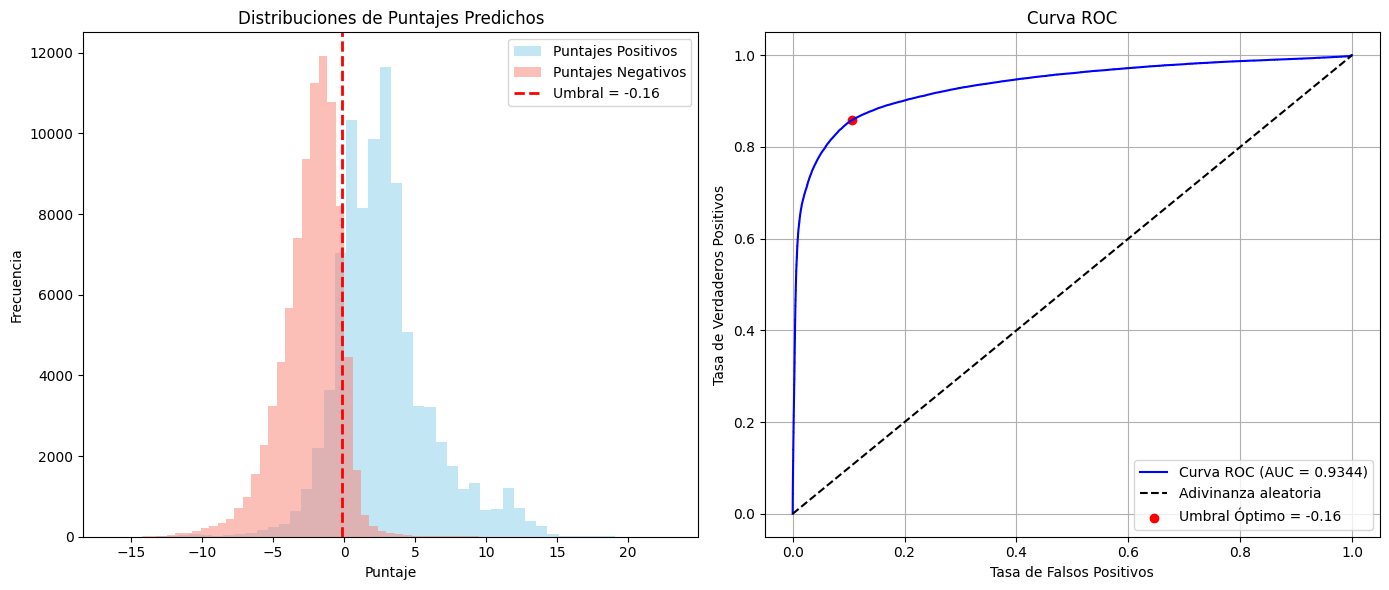

AUC: 0.9344
Optimal Threshold: -0.1568
Accuracy: 0.8763 (Threshold: -0.16)
Training model: GraphSAGE ----------------------------------------------- 

In epoch 0, loss: 0.7101895213127136
In epoch 5, loss: 0.669815182685852
In epoch 10, loss: 0.632432758808136
In epoch 15, loss: 0.5803964734077454
In epoch 20, loss: 0.5225358605384827
In epoch 25, loss: 0.4499109983444214
In epoch 30, loss: 0.3782166838645935
In epoch 35, loss: 0.32061049342155457
In epoch 40, loss: 0.27956607937812805
In epoch 45, loss: 0.25186893343925476
In epoch 50, loss: 0.23256559669971466
In epoch 55, loss: 0.21813635528087616
In epoch 60, loss: 0.20948345959186554
In epoch 65, loss: 0.1995798647403717
In epoch 70, loss: 0.1929125189781189
In epoch 75, loss: 0.18734398484230042
In epoch 80, loss: 0.181752547621727
In epoch 85, loss: 0.17593538761138916
In epoch 90, loss: 0.1753719002008438
In epoch 95, loss: 0.17132465541362762
AUC 0.9784994532115143


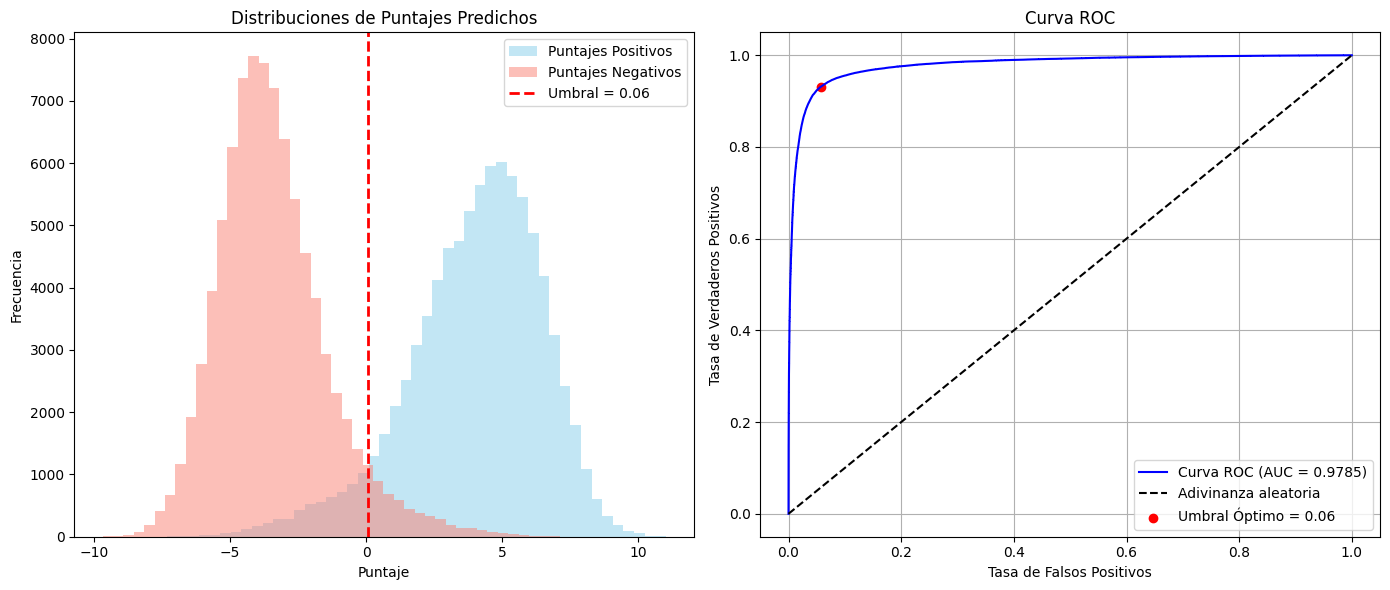

AUC: 0.9785
Optimal Threshold: 0.0600
Accuracy: 0.9370 (Threshold: 0.06)
Training model: GAT ----------------------------------------------- 

In epoch 0, loss: 0.7164642810821533
In epoch 5, loss: 0.6918120980262756
In epoch 10, loss: 0.680623471736908
In epoch 15, loss: 0.6754697561264038
In epoch 20, loss: 0.6692641377449036
In epoch 25, loss: 0.6625170111656189
In epoch 30, loss: 0.6552191376686096
In epoch 35, loss: 0.6358567476272583
In epoch 40, loss: 0.6195198893547058
In epoch 45, loss: 0.5998877286911011
In epoch 50, loss: 0.5612124800682068
In epoch 55, loss: 0.5149495005607605
In epoch 60, loss: 0.4795587360858917
In epoch 65, loss: 0.4279429018497467
In epoch 70, loss: 0.4158652126789093
In epoch 75, loss: 0.4032445251941681
In epoch 80, loss: 0.3718516230583191
In epoch 85, loss: 0.3900264799594879
In epoch 90, loss: 0.38090935349464417
In epoch 95, loss: 0.35630539059638977
AUC 0.9253069422842664


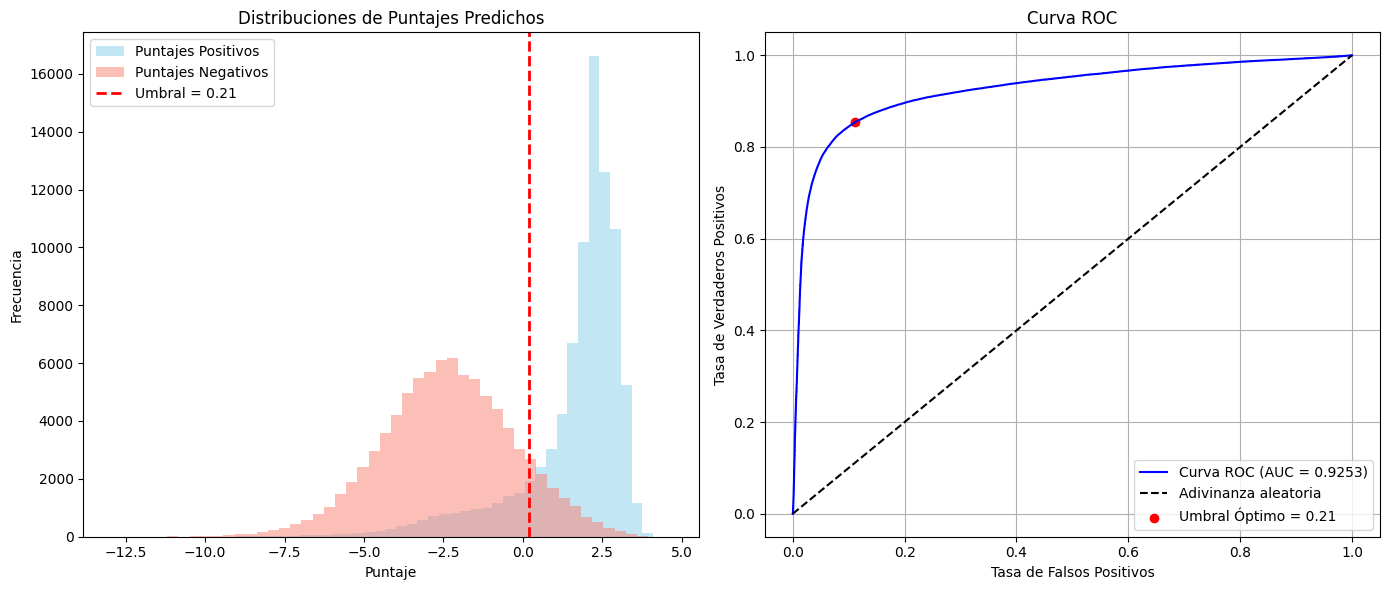

AUC: 0.9253
Optimal Threshold: 0.2082
Accuracy: 0.8713 (Threshold: 0.21)


In [ ]:
decoder = 'MLP'
in_feats = gnn.dgl_graph.ndata['feat'].shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("Training model: {} ----------------------------------------------- \n".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 1.- Entrenamiento 
    # --------------------------
    train_losses = []
    test_losses = []
    
    for e in range(NUM_EPOCHS):

        # forward
        model.train()
        h = model.encode(gnn.train_g, gnn.train_g.ndata['feat'])
        pos_score = model.decodeMLP(gnn.train_pos_g, h)
        neg_score = model.decodeMLP(gnn.train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        train_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluar en test set
        model.eval()
        with torch.no_grad():
            h_eval = model.encode(gnn.train_g, gnn.train_g.ndata['feat'])
            pos_score_test = model.decodeMLP(gnn.test_pos_g, h_eval)
            neg_score_test = model.decodeMLP(gnn.test_neg_g, h_eval)
            test_loss = compute_loss(pos_score_test, neg_score_test)
            test_losses.append(test_loss.item())

        if e % 10 == 0:
            print('In epoch {}, train loss: {:.6f}, test loss: {:.6f}'.format(e, loss.item(), test_loss.item()))

    # Visualizar evolución del loss
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (MLP): Evolución del Loss',
                       test_losses=test_losses)

    # 3.- Check de resultados 
    # --------------------------
    with torch.no_grad():
        pos_score = model.decodeMLP(gnn.test_pos_g, h_eval)
        neg_score = model.decodeMLP(gnn.test_neg_g, h_eval)
        print("AUC", compute_auc(pos_score, neg_score))
        threshold = plot_roc_with_distributions(pos_score, neg_score,model_name+'_'+decoder+'_'+attr,"Caso2")
        compute_accuracy(pos_score, neg_score, threshold=threshold)
    
    # 4.- Guardar modelo 
    # --------------------------
    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso2' + f'/model_emb_{decoder}_{model_name}_{attr}.pth')

    # 5.- Guardar embeddings
    # ------------------------
    torch.save(h_eval, DATA_PATH + 'resultados/EnfoquePorPartes/Caso2'  + f"/embeddings_ribs_{decoder}_{model_name}_{attr}.pt")

## Creación embeddinsg a aprtir de la predicción de atributos:

### Caso 3: Predicción del grado de los nodos utilizando grafo con atributos extraidos de PeeringDB

In [47]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

# CASO 3: Grafo con atributos de nodos extraídos de PeeringDB
# ---------------------------------------
attr = 'out_degree'
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'


In [ ]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...

gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE,
                 force_reload=True,
                 index_graph=index_graph)

gnn.split_graph_nodes(train_size=0.8)

In [49]:
degrees = gnn.dgl_graph.out_degrees(gnn.dgl_graph.nodes()).float().unsqueeze(1)

# Transformación logarítmica
deg_log = torch.log1p(degrees)  # log(1 + x)

# Min-max normalization después del log
min_val = deg_log.min()
max_val = deg_log.max()
deg_log_norm = (deg_log - min_val) / (max_val - min_val + 1e-8)

gnn.dgl_graph.ndata['out_degree'] = deg_log_norm


In [51]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}


Training model: GCN ----------------------------------------------- 
In epoch 0, loss: 0.43098020553588867
Epoch 0: Train MSE = 0.419000, Test MSE = 0.418494
In epoch 10, loss: 0.32442760467529297
In epoch 20, loss: 0.22031785547733307
Epoch 20: Train MSE = 0.212724, Test MSE = 0.214879
In epoch 30, loss: 0.17907007038593292
Epoch 39: Train MSE = 0.152802, Test MSE = 0.154462
Embeddings shape: torch.Size([42476, 32])

[Métricas finales para GCN]
Test MSE: 0.154462
Test MAE: 0.154462
Test R²: -17.954386


/tmp/ipykernel_4608/1927584204.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


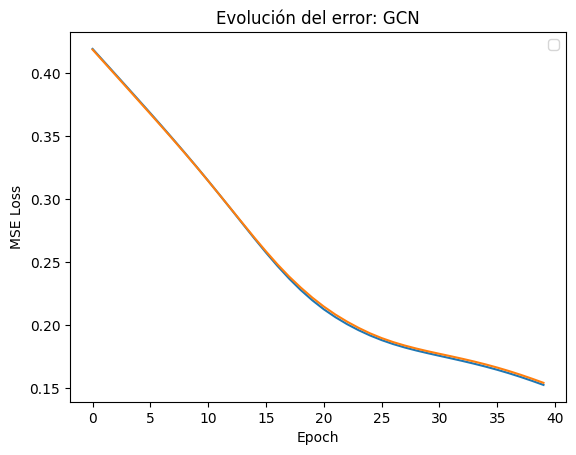

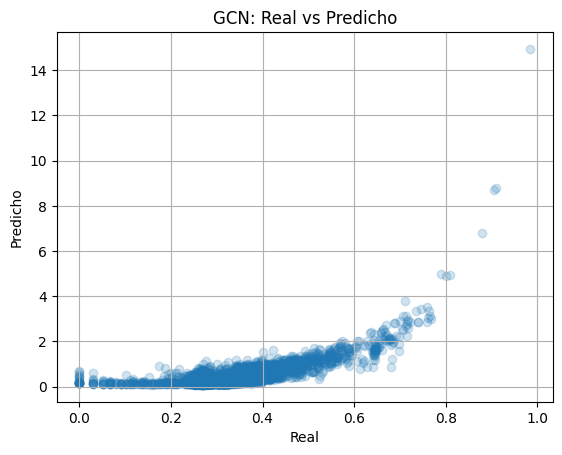


Training model: GraphSAGE ----------------------------------------------- 
In epoch 0, loss: 0.37375178933143616
Epoch 0: Train MSE = 0.279706, Test MSE = 0.279149
In epoch 10, loss: 0.21542389690876007
In epoch 20, loss: 0.1485375314950943
Epoch 20: Train MSE = 0.089187, Test MSE = 0.089281
In epoch 30, loss: 0.1125841811299324
Epoch 39: Train MSE = 0.060256, Test MSE = 0.060429
Embeddings shape: torch.Size([42476, 32])

[Métricas finales para GraphSAGE]
Test MSE: 0.060429
Test MAE: 0.060429
Test R²: -0.303187


/tmp/ipykernel_4608/1927584204.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


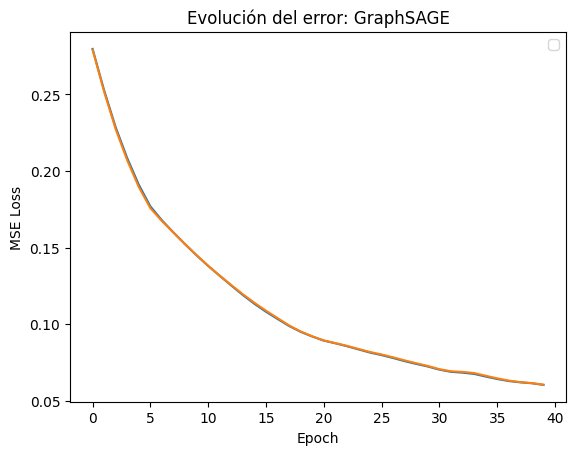

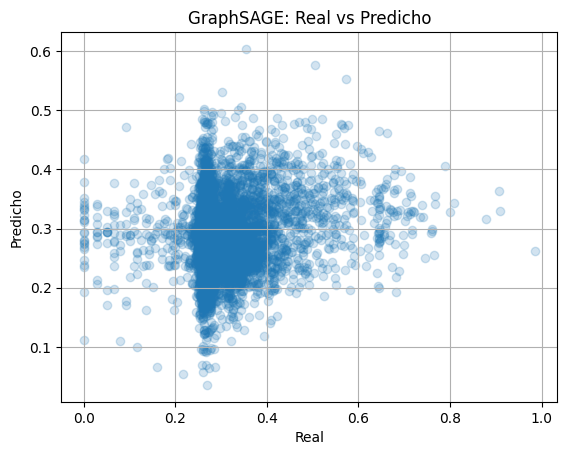


Training model: GAT ----------------------------------------------- 
In epoch 0, loss: 0.48604917526245117
Epoch 0: Train MSE = 0.440766, Test MSE = 0.440445
In epoch 10, loss: 0.1213541030883789
Early stopping en epoch 18! Mejor test MSE: 0.079224
Embeddings shape: torch.Size([42476, 32])

[Métricas finales para GAT]
Test MSE: 0.099608
Test MAE: 0.099608
Test R²: -1.737621


/tmp/ipykernel_4608/1927584204.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


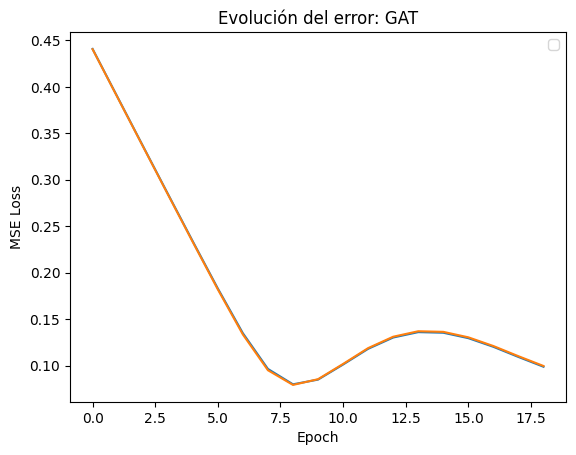

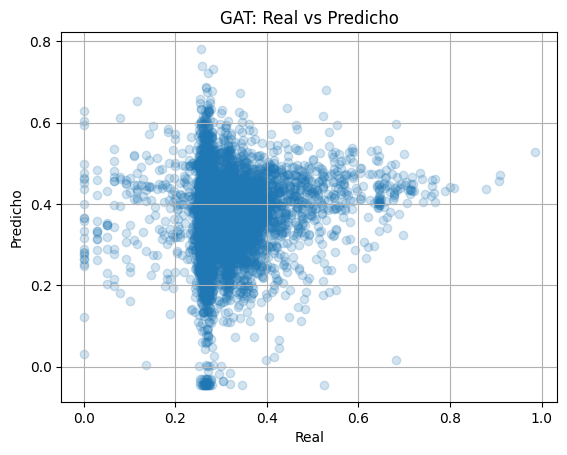

In [ ]:
attr = 'out_degree'


features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.ndata[attr]

train_mask = gnn.dgl_graph.ndata['train_mask']
test_mask = gnn.dgl_graph.ndata['test_mask']


in_feats = features.shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1
lr = 0.001
epochs = 40

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("\nTraining model: {} ----------------------------------------------- ".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
        
    
    # loKss_fn = nn.MSELoss()
    loss_fn = nn.L1Loss()        # MAE
    # loss_fn = nn.SmoothL1Loss()  # Huber

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    # 2.- Entrenamiento
    # --------------------
    for epoch in range(epochs):
        model.train()

        pred = model.encode(gnn.dgl_graph, features)
        loss = loss_fn(pred[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
        
        model.eval()
        with torch.no_grad():
            pred_eval = model.encode(gnn.dgl_graph, features)
            train_mse = loss_fn(pred_eval[train_mask], labels[train_mask]).item()
            test_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

            train_losses.append(train_mse)
            test_losses.append(test_mse)

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train Error (MAE) = {train_mse:.6f}, Test Error (MAE) = {test_mse:.6f}")

        # 3.- Check de resultados 
        # --------------------------
        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test Error (MAE): {best_test_loss:.6f}")
            break

    with torch.no_grad():
        embeddings = model.encode(gnn.dgl_graph, features)
        print(f"Embeddings shape: {embeddings.shape}")

    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso3' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(embeddings, DATA_PATH + 'resultados/EnfoquePorPartes/Caso3' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    # Métricas finales
    pred_test = pred_eval[test_mask].cpu().numpy().flatten()
    labels_test = labels[test_mask].cpu().numpy().flatten()

    final_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

    mae = mean_absolute_error(labels_test, pred_test)
    r2 = r2_score(labels_test, pred_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MSE: {final_mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"Test R²: {r2:.6f}")

    # Plot evolución del error
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name}: Evolución del Error (MAE)',
                       test_losses=test_losses)

    plt.scatter(labels_test, pred_test, alpha=0.2)
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"{model_name}: Real vs Predicho")
    plt.grid(True)
    plt.show()



ESTADÍSTICAS DEL GRAFO
Número de nodos (ASes): 42,164
Número de aristas: 3,325,784
Densidad del grafo: 0.001871

Grado de entrada promedio: 78.88
Grado de salida promedio: 78.88
Grado de entrada máximo: 184238
Grado de salida máximo: 184187


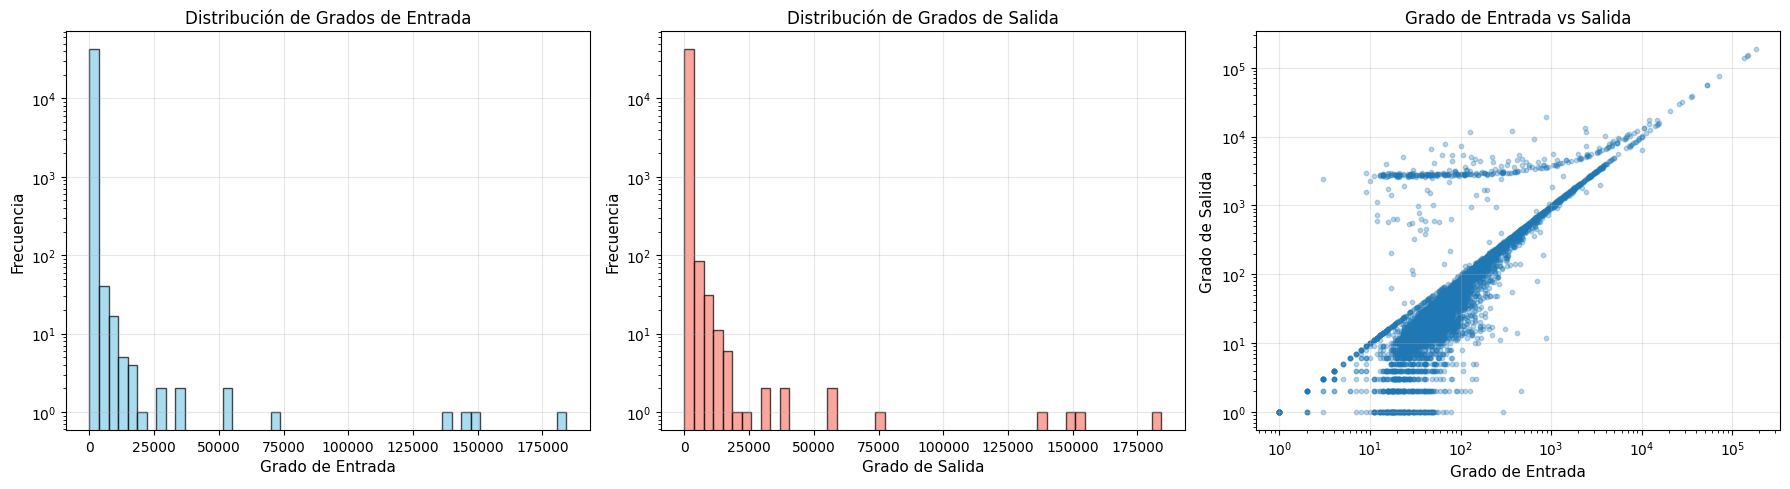

In [94]:
# Estadísticas del grafo
num_nodes = gnn.dgl_graph.num_nodes()
num_edges = gnn.dgl_graph.num_edges()
in_degrees = gnn.dgl_graph.in_degrees().numpy()
out_degrees = gnn.dgl_graph.out_degrees().numpy()

print("=" * 60)
print("ESTADÍSTICAS DEL GRAFO")
print("=" * 60)
print(f"Número de nodos (ASes): {num_nodes:,}")
print(f"Número de aristas: {num_edges:,}")
print(f"Densidad del grafo: {num_edges / (num_nodes * (num_nodes - 1)):.6f}")
print(f"\nGrado de entrada promedio: {in_degrees.mean():.2f}")
print(f"Grado de salida promedio: {out_degrees.mean():.2f}")
print(f"Grado de entrada máximo: {in_degrees.max()}")
print(f"Grado de salida máximo: {out_degrees.max()}")

# Visualizar distribución de grados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de grados de entrada
axes[0].hist(in_degrees, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Grado de Entrada', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].set_title('Distribución de Grados de Entrada', fontsize=12)
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Histograma de grados de salida
axes[1].hist(out_degrees, bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Grado de Salida', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Grados de Salida', fontsize=12)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Scatter plot: in-degree vs out-degree
axes[2].scatter(in_degrees, out_degrees, alpha=0.3, s=10)
axes[2].set_xlabel('Grado de Entrada', fontsize=11)
axes[2].set_ylabel('Grado de Salida', fontsize=11)
axes[2].set_title('Grado de Entrada vs Salida', fontsize=12)
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Caso 4: Predicción del valor de PageRank utilizando grafo con atributos extraídos de PeeringDB

In [103]:
models = {
    'GCN': GCN,
    'GraphSAGE': GraphSAGE,
    'GAT': GAT,
}

In [105]:
attr = 'pagerank'
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'

In [106]:
# Cargar grafo 
# ---------------------- 
index_graph = 1  # Febrero
gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE, 
                 force_reload=True,
                 index_graph=index_graph) 

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)
gnn.split_graph_nodes(train_size=0.8)
print("Train mask:", 'train_mask' in gnn.dgl_graph.ndata)
print("Test mask:", 'test_mask' in gnn.dgl_graph.ndata)

[LOAD DATASET] Leyendo CSV …
Done saving data into cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42242, num_edges=3324283,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({-1: 3324283})
[ATTR SHAPE]:  torch.Size([42242, 68])
Train nodes: 33793, Test nodes: 8449
Train mask: True
Test mask: True


Calculo PageRank

In [107]:
N = gnn.dgl_graph.number_of_nodes()
DAMP = 0.85
K = 10


def compute_pagerank(g):
    g.ndata["pv"] = torch.ones(N) / N
    degrees = g.out_degrees(g.nodes()).type(torch.float32)
    degrees = torch.clamp(degrees, min=1)  # evita div/0 si hay nodos sin out-degree
    for k in range(K):
        g.ndata["pv"] = g.ndata["pv"] / degrees
        g.update_all(
            message_func=fn.copy_u(u="pv", out="m"),
            reduce_func=fn.sum(msg="m", out="pv"),
        )
        g.ndata["pv"]  = (1 - DAMP) / N + DAMP * g.ndata["pv"]
    g.ndata["pv"]  = g.ndata["pv"].unsqueeze(1)
    return g.ndata["pv"]


# Calcular PageRank  
# ----------------------------------------

pv = compute_pagerank(gnn.dgl_graph)
gnn.dgl_graph.ndata['pagerank'] = pv

# Normalización min-max 
# ------------------------------------
pr        = pv.squeeze()                    # (N,)
pr_min    = pr.min()
pr_max    = pr.max()
eps       = 1e-12                           # evita div/0
pr_norm   = (pr - pr_min) / (pr_max - pr_min + eps)
gnn.dgl_graph.ndata['pagerank_norm'] = pr_norm.unsqueeze(1)

In [108]:
gnn.dgl_graph

Graph(num_nodes=42242, num_edges=3324283,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'pv': Scheme(shape=(1,), dtype=torch.float32), 'pagerank': Scheme(shape=(1,), dtype=torch.float32), 'pagerank_norm': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.int8)})

Encode: DotProduct


Training model: GCN ----------------------------------------------- 


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([33793, 1])) that is different to the input size (torch.Size([33793, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0: Train Error (MAE) = 0.155105, Test Error (MAE) = 0.155274
Epoch 10: Train Error (MAE) = 0.161430, Test Error (MAE) = 0.161683
Early stopping en epoch 10! Mejor test Error (MAE): 0.155274
Embeddings shape: torch.Size([42242, 32])

[Métricas finales para GCN]
Test MAE: 0.161683
Test MSE: 0.161683
Test R²: -210.922104


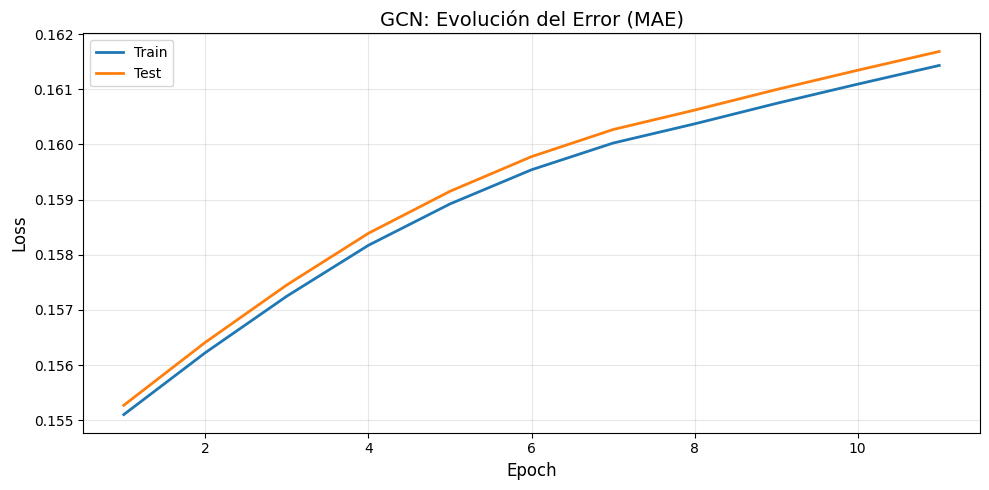

Loss inicial: 0.1551
Loss final: 0.1614
Reducción: -4.08%

Test Loss inicial: 0.1553
Test Loss final: 0.1617


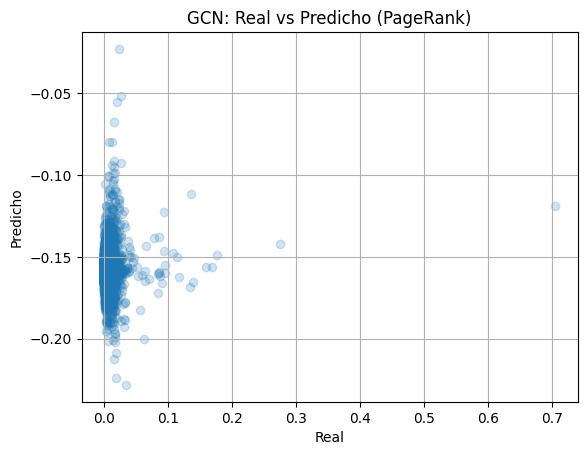


Training model: GraphSAGE ----------------------------------------------- 
Epoch 0: Train Error (MAE) = 0.282899, Test Error (MAE) = 0.284985


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([33793, 1])) that is different to the input size (torch.Size([33793, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 10: Train Error (MAE) = 0.243274, Test Error (MAE) = 0.244366
Epoch 20: Train Error (MAE) = 0.196569, Test Error (MAE) = 0.197054
Epoch 30: Train Error (MAE) = 0.148541, Test Error (MAE) = 0.148877
Epoch 39: Train Error (MAE) = 0.114959, Test Error (MAE) = 0.115384
Epoch 40: Train Error (MAE) = 0.112007, Test Error (MAE) = 0.112459
Epoch 50: Train Error (MAE) = 0.089047, Test Error (MAE) = 0.089740
Epoch 60: Train Error (MAE) = 0.074039, Test Error (MAE) = 0.074879
Epoch 70: Train Error (MAE) = 0.064373, Test Error (MAE) = 0.065433
Epoch 80: Train Error (MAE) = 0.057170, Test Error (MAE) = 0.058089
Epoch 90: Train Error (MAE) = 0.052087, Test Error (MAE) = 0.052730
Embeddings shape: torch.Size([42242, 32])

[Métricas finales para GraphSAGE]
Test MAE: 0.049071
Test MSE: 0.049071
Test R²: -27.821135


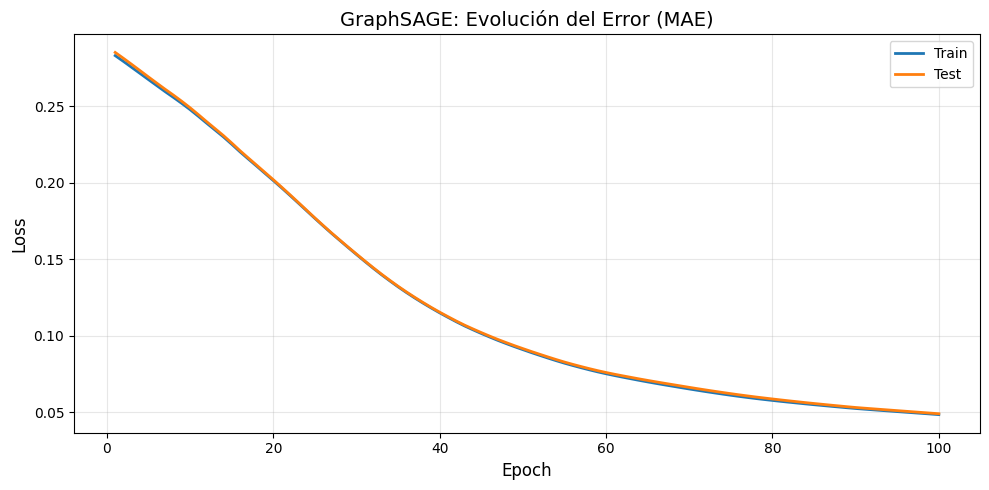

Loss inicial: 0.2829
Loss final: 0.0485
Reducción: 82.86%

Test Loss inicial: 0.2850
Test Loss final: 0.0491


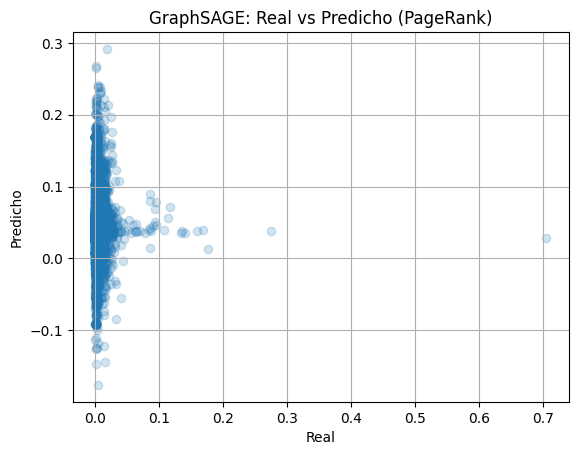


Training model: GAT ----------------------------------------------- 


/home/valentina/Desktop/TrabajoTesis/env310/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([33793, 1])) that is different to the input size (torch.Size([33793, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0: Train Error (MAE) = 0.133735, Test Error (MAE) = 0.132289
Epoch 10: Train Error (MAE) = 0.071128, Test Error (MAE) = 0.069870
Epoch 20: Train Error (MAE) = 0.052666, Test Error (MAE) = 0.051559
Epoch 30: Train Error (MAE) = 0.051785, Test Error (MAE) = 0.050513
Epoch 39: Train Error (MAE) = 0.049228, Test Error (MAE) = 0.048169
Epoch 40: Train Error (MAE) = 0.048848, Test Error (MAE) = 0.047813
Epoch 50: Train Error (MAE) = 0.047077, Test Error (MAE) = 0.046017
Epoch 60: Train Error (MAE) = 0.046542, Test Error (MAE) = 0.045442
Epoch 70: Train Error (MAE) = 0.045998, Test Error (MAE) = 0.045024
Epoch 80: Train Error (MAE) = 0.042654, Test Error (MAE) = 0.041901
Epoch 90: Train Error (MAE) = 0.039607, Test Error (MAE) = 0.039048
Embeddings shape: torch.Size([42242, 32])

[Métricas finales para GAT]
Test MAE: 0.037825
Test MSE: 0.037825
Test R²: -15.152018


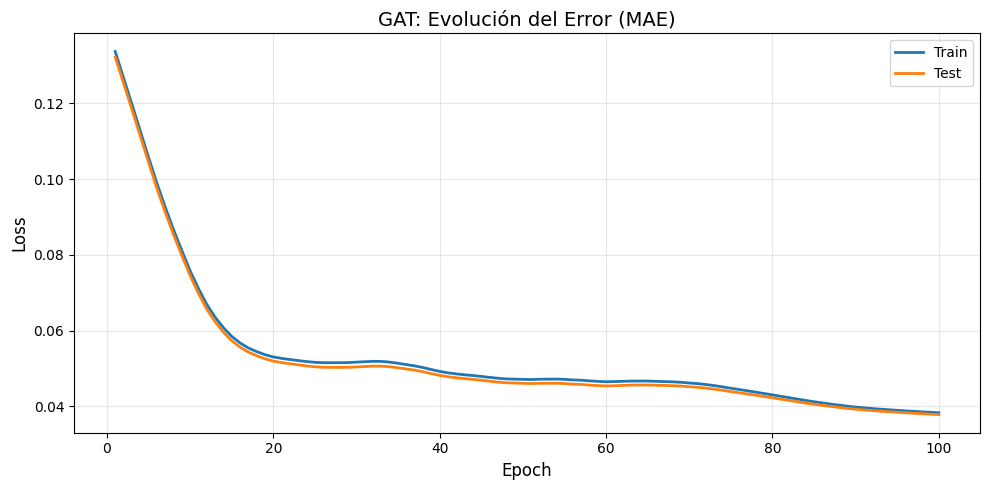

Loss inicial: 0.1337
Loss final: 0.0383
Reducción: 71.36%

Test Loss inicial: 0.1323
Test Loss final: 0.0378


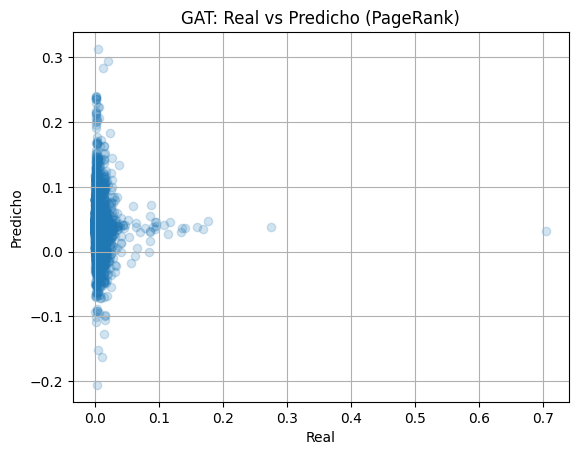

In [112]:
attr = 'pagerank_norm'

features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.ndata[attr]

train_mask = gnn.dgl_graph.ndata['train_mask']
test_mask = gnn.dgl_graph.ndata['test_mask']

in_feats = features.shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1
lr = 0.001

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("\nTraining model: {} ----------------------------------------------- ".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    loss_fn = nn.L1Loss()        # MAE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    # 2.- Entrenamiento
    # --------------------
    for epoch in range(NUM_EPOCHS):
        model.train()

        pred = model.encode(gnn.dgl_graph, features)
        loss = loss_fn(pred[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            pred_eval = model(gnn.dgl_graph, features)
            train_mse = loss_fn(pred_eval[train_mask], labels[train_mask]).item()
            test_mse = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

            train_losses.append(train_mse)
            test_losses.append(test_mse)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train Error (MAE) = {train_mse:.6f}, Test Error (MAE) = {test_mse:.6f}")

        # Early stopping
        if test_mse < best_test_loss:
            best_test_loss = test_mse
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test Error (MAE): {best_test_loss:.6f}")
            break

    # 3.- Check de resultados y guardar
    # -----------------------------------
    with torch.no_grad():
        embeddings = model.encode(gnn.dgl_graph, features)
        print(f"Embeddings shape: {embeddings.shape}")

    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso4' + f'/model_emb_{model_name}_{attr}_febrero.pth')
    torch.save(embeddings, DATA_PATH + 'resultados/EnfoquePorPartes/Caso4' + f"/embeddings_ribs_{model_name}_{attr}_febrero.pt")

    # Métricas finales
    pred_test = pred_eval[test_mask].cpu().numpy().flatten()
    labels_test = labels[test_mask].cpu().numpy().flatten()

    final_mae = loss_fn(pred_eval[test_mask], labels[test_mask]).item()
    mse = mean_absolute_error(labels_test, pred_test)
    r2 = r2_score(labels_test, pred_test)

    print(f"\n[Métricas finales para {model_name}]")
    print(f"Test MAE: {final_mae:.6f}")
    print(f"Test MSE: {mse:.6f}")
    print(f"Test R²: {r2:.6f}")

    # Plot evolución del error
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name}: Evolución del Error (MAE)',
                       test_losses=test_losses)

    plt.scatter(labels_test, pred_test, alpha=0.2)
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title(f"{model_name}: Real vs Predicho (PageRank)")
    plt.grid(True)
    plt.show()

Encode: MLP


Training model: GCN (MLP Regressor) ----------------------------------------------- 
Epoch 0: Train MAE = 0.071051, Test MAE = 0.071255
Epoch 10: Train MAE = 0.035152, Test MAE = 0.034007
Epoch 20: Train MAE = 0.019830, Test MAE = 0.019503
Epoch 30: Train MAE = 0.009719, Test MAE = 0.009517
Epoch 39: Train MAE = 0.008344, Test MAE = 0.007937
Epoch 40: Train MAE = 0.008236, Test MAE = 0.007827
Epoch 50: Train MAE = 0.004779, Test MAE = 0.004614
Epoch 60: Train MAE = 0.003674, Test MAE = 0.003575
Epoch 70: Train MAE = 0.002969, Test MAE = 0.002841
Epoch 80: Train MAE = 0.002490, Test MAE = 0.002375
Epoch 90: Train MAE = 0.002274, Test MAE = 0.002182
Embeddings shape: torch.Size([42242, 32])

[Métricas finales para GCN con MLP]
Test MAE: 0.001997
Test MSE: 0.001997
Test R²: 0.192136


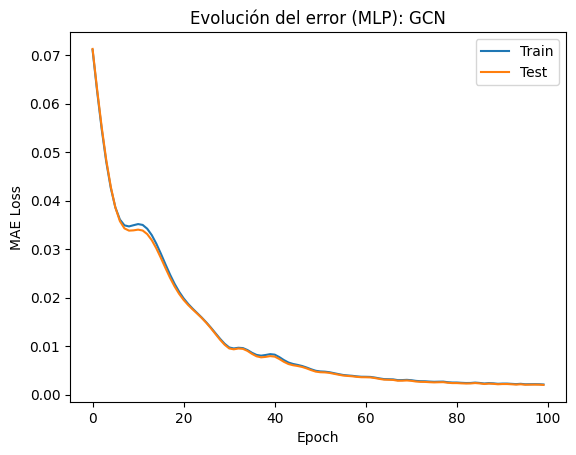

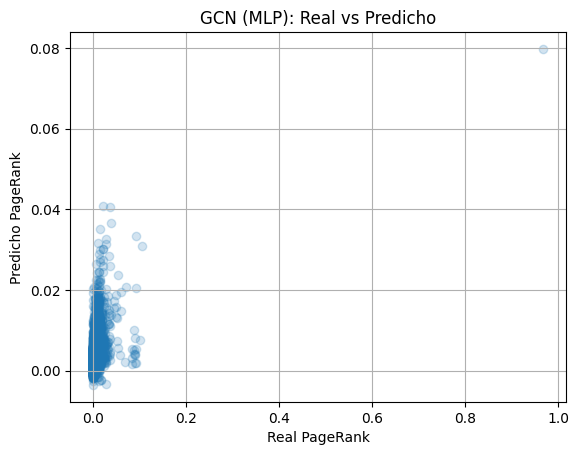


Training model: GraphSAGE (MLP Regressor) ----------------------------------------------- 
Epoch 0: Train MAE = 0.249251, Test MAE = 0.252992
Epoch 10: Train MAE = 0.138640, Test MAE = 0.140915
Epoch 20: Train MAE = 0.104128, Test MAE = 0.105972
Epoch 30: Train MAE = 0.065406, Test MAE = 0.066109
Epoch 39: Train MAE = 0.053036, Test MAE = 0.053583
Epoch 40: Train MAE = 0.051354, Test MAE = 0.051919
Epoch 50: Train MAE = 0.039228, Test MAE = 0.039640
Epoch 60: Train MAE = 0.030562, Test MAE = 0.030999
Epoch 70: Train MAE = 0.024358, Test MAE = 0.024788
Epoch 80: Train MAE = 0.019107, Test MAE = 0.019496
Epoch 90: Train MAE = 0.015014, Test MAE = 0.015302
Embeddings shape: torch.Size([42242, 32])

[Métricas finales para GraphSAGE con MLP]
Test MAE: 0.012586
Test MSE: 0.012586
Test R²: -1.775286


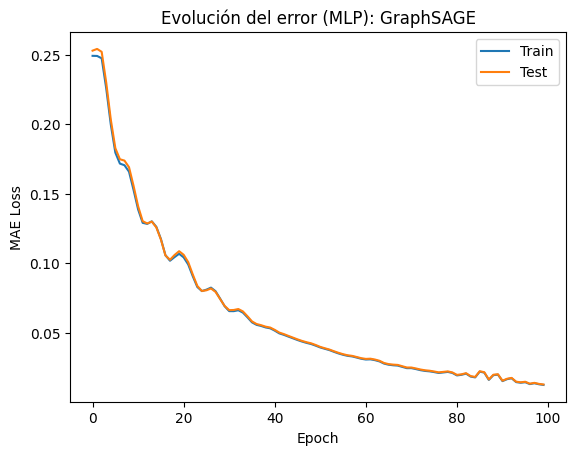

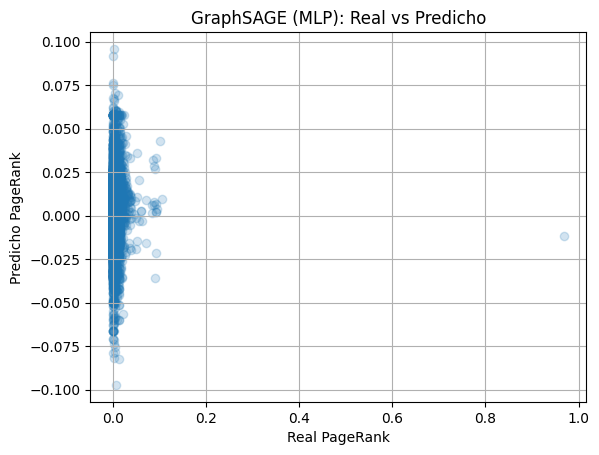


Training model: GAT (MLP Regressor) ----------------------------------------------- 
Epoch 0: Train MAE = 0.061567, Test MAE = 0.061129
Epoch 10: Train MAE = 0.053762, Test MAE = 0.053212
Epoch 20: Train MAE = 0.029902, Test MAE = 0.029278
Epoch 30: Train MAE = 0.026300, Test MAE = 0.026113
Epoch 39: Train MAE = 0.017026, Test MAE = 0.016599
Epoch 40: Train MAE = 0.017073, Test MAE = 0.016721
Epoch 50: Train MAE = 0.013153, Test MAE = 0.012868
Epoch 60: Train MAE = 0.009893, Test MAE = 0.009671
Epoch 70: Train MAE = 0.007506, Test MAE = 0.007357
Epoch 80: Train MAE = 0.006360, Test MAE = 0.006246
Epoch 90: Train MAE = 0.004312, Test MAE = 0.004199
Embeddings shape: torch.Size([42242, 32])

[Métricas finales para GAT con MLP]
Test MAE: 0.003939
Test MSE: 0.003939
Test R²: -0.115869


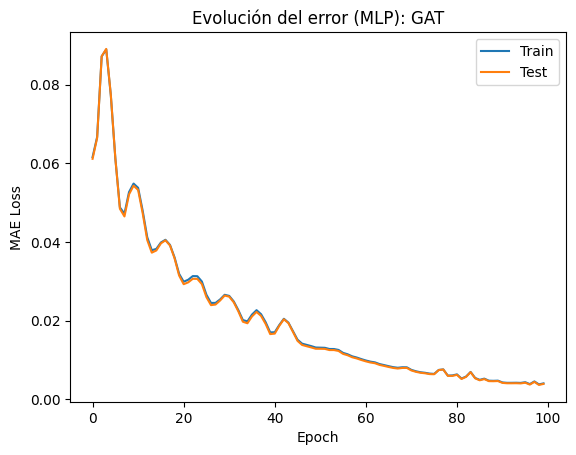

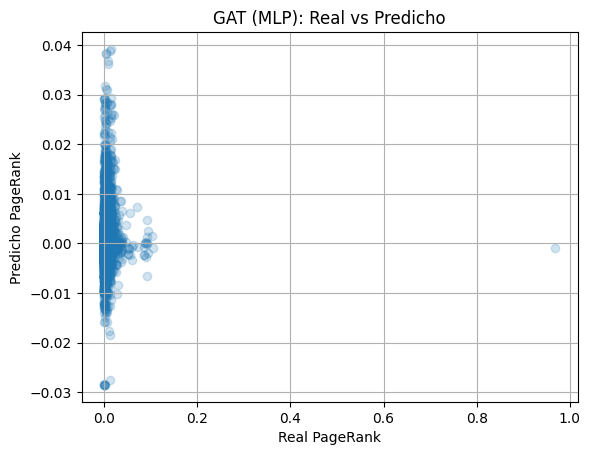

In [ ]:
attr = 'pagerank_norm'

features = gnn.dgl_graph.ndata['feat']
labels = gnn.dgl_graph.ndata[attr]

train_mask = gnn.dgl_graph.ndata['train_mask']
test_mask = gnn.dgl_graph.ndata['test_mask']

in_feats = features.shape[1]
hidden_feats = 64 
out_feats = 32
out_feats_mlp = 1
lr = 0.001
epochs = 40

# 1.- Entrenamiento de cada modelo
# -----------------------------------
for model_name in models:

    print("\nTraining model: {} (MLP Regressor) ----------------------------------------------- ".format(model_name))

    model = models[model_name](
        in_feats=in_feats,
        hidden_feats=hidden_feats,
        out_feats=out_feats,
        out_feats_mlp=out_feats_mlp)
    
    loss_fn = nn.L1Loss()        # MAE
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 10
    patience_counter = 0

    # 2.- Entrenamiento
    # --------------------
    for epoch in range(NUM_EPOCHS):
        model.train()

        pred = model(gnn.dgl_graph, features)
        loss = loss_fn(pred[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            pred_eval = model(gnn.dgl_graph, features)
            train_mae = loss_fn(pred_eval[train_mask], labels[train_mask]).item()
            test_mae = loss_fn(pred_eval[test_mask], labels[test_mask]).item()

            train_losses.append(train_mae)
            test_losses.append(test_mae)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}: Train Error (MAE) = {train_mae:.6f}, Test Error (MAE) = {test_mae:.6f}")

        # Early stopping
        if test_mae < best_test_loss:
            best_test_loss = test_mae
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch}! Mejor test Error (MAE): {best_test_loss:.6f}")
            break

    # 3.- Check de resultados y guardar
    # -----------------------------------
    with torch.no_grad():
        embeddings = model.encode(gnn.dgl_graph, features)
        print(f"Embeddings shape: {embeddings.shape}")

    torch.save(model.state_dict(), DATA_PATH + 'resultados/EnfoquePorPartes/Caso4' + f'/model_mlp_{model_name}_{attr}_febrero.pth')
    torch.save(embeddings, DATA_PATH + 'resultados/EnfoquePorPartes/Caso4' + f"/embeddings_mlp_{model_name}_{attr}_febrero.pt")

    # Métricas finales
    pred_test = pred_eval[test_mask].cpu().numpy().flatten()
    labels_test = labels[test_mask].cpu().numpy().flatten()

    final_mae = loss_fn(pred_eval[test_mask], labels[test_mask]).item()
    mse = mean_absolute_error(labels_test, pred_test)
    r2 = r2_score(labels_test, pred_test)

    print(f"\n[Métricas finales para {model_name} con MLP]")
    print(f"Test MAE: {final_mae:.6f}")
    print(f"Test MSE: {mse:.6f}")
    print(f"Test R²: {r2:.6f}")

    # Plot evolución del error
    plot_loss_evolution(train_losses, len(train_losses), 
                       title=f'{model_name} (MLP): Evolución del Error (MAE)',
                       test_losses=test_losses)

    plt.scatter(labels_test, pred_test, alpha=0.2)
    plt.xlabel("Real PageRank")
    plt.ylabel("Predicho PageRank")
    plt.title(f"{model_name} (MLP): Real vs Predicho")
    plt.grid(True)
    plt.show()

In [ ]:
# Distribución de PageRank normalizado (min-max)
pr_norm = gnn.dgl_graph.ndata['pagerank_norm'].squeeze().detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.hist(pr_norm, bins=100, alpha=0.85, edgecolor='black', linewidth=0.3)
plt.title('Distribución de PageRank normalizado')
plt.xlabel('PageRank normalizado')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.35)
plt.tight_layout()
plt.show()

## Otros: DeepWalk

### Caso 5.1: DeepWalk

In [85]:
# CASO 5.1: Grafo con atributos de nodos generados con PeeringDB
# ---------------------------------------
attr = 'deepWalk'
INTERNETGRAPH_FILE = DATA_PATH + 'dgl_graph/2024/peeringdb/'

In [88]:
index_graph = int(month_name_to_number(MES))  # 0 = enero ; 1 = febrero ; 2 = marzo ; 3 = abril ; ...

gnn = GNN(debug=True)
gnn.load_dataset(INTERNETGRAPH_FILE, 
                 force_reload=True,
                 index_graph=index_graph)

[LOAD DATASET] Leyendo CSV …
Done saving data into cached files.
[LOAD DATASET] Grafo Graph(num_nodes=42164, num_edges=3325784,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={})
[LOAD DATASET] etiquetas 0/1/2/-1 → Counter({-1: 3325784})


In [93]:
# Configuración del modelo DeepWalk
# -------------------------------------
model = DeepWalk(
    gnn.dgl_graph,
    emb_dim=32,
    walk_length=40,
    window_size=1
)

# DataLoader para muestreo de caminatas aleatorias
# -------------------------------------------------
# Usar explícitamente el DataLoader de PyTorch (no el de DGL)
import torch.utils.data
dataloader = torch.utils.data.DataLoader(
    torch.arange(gnn.dgl_graph.num_nodes()),
    batch_size=128,
    shuffle=True,
    collate_fn=model.sample
)

optimizer = SparseAdam(model.parameters(), lr=0.01)

# Entrenamiento
# -------------------------------------
losses = []

print("=" * 60)
print("Iniciando entrenamiento de DeepWalk...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    num_batches = 0
    
    for batch_walk in dataloader:
        # Identificar cuáles filas NO tienen -1 (caminatas válidas)
        valid_mask = ~(batch_walk == -1).any(dim=1)
        
        # Filtrar filas válidas
        batch_walk_clean = batch_walk[valid_mask]
        
        # Si no hay caminatas válidas en el batch, continuar
        if batch_walk_clean.size(0) == 0:
            continue

        # Forward + backward
        loss = model(batch_walk_clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calcular pérdida promedio de la época
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
    losses.append(avg_loss)
    
    # Mostrar progreso
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS}: Loss = {avg_loss:.6f}")

print("\n" + "=" * 60)
print("Entrenamiento completado!")
print("=" * 60)

# Obtener embeddings finales
# -------------------------------------
embeddings = model.node_embed.weight.detach().cpu()

print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Número de nodos: {gnn.dgl_graph.num_nodes()}")
print(f"Dimensión de embeddings: {embeddings.shape[1]}")
print(f"\nLoss inicial: {losses[0]:.6f}")
print(f"Loss final: {losses[-1]:.6f}")
print(f"Reducción: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")

Iniciando entrenamiento de DeepWalk...
Epoch   1/100: Loss = 4.144597
Epoch  10/100: Loss = 2.477357
Epoch  20/100: Loss = 2.220879
Epoch  30/100: Loss = 2.107334
Epoch  40/100: Loss = 2.093735
Epoch  50/100: Loss = 2.080531
Epoch  60/100: Loss = 2.060437
Epoch  70/100: Loss = 2.075189
Epoch  80/100: Loss = 2.075549
Epoch  90/100: Loss = 2.046725
Epoch 100/100: Loss = 2.054774

Entrenamiento completado!

Embeddings shape: torch.Size([42164, 32])
Número de nodos: 42164
Dimensión de embeddings: 32

Loss inicial: 4.144597
Loss final: 2.054774
Reducción: 50.42%


### Visualización 1: Evolución del Loss durante el entrenamiento

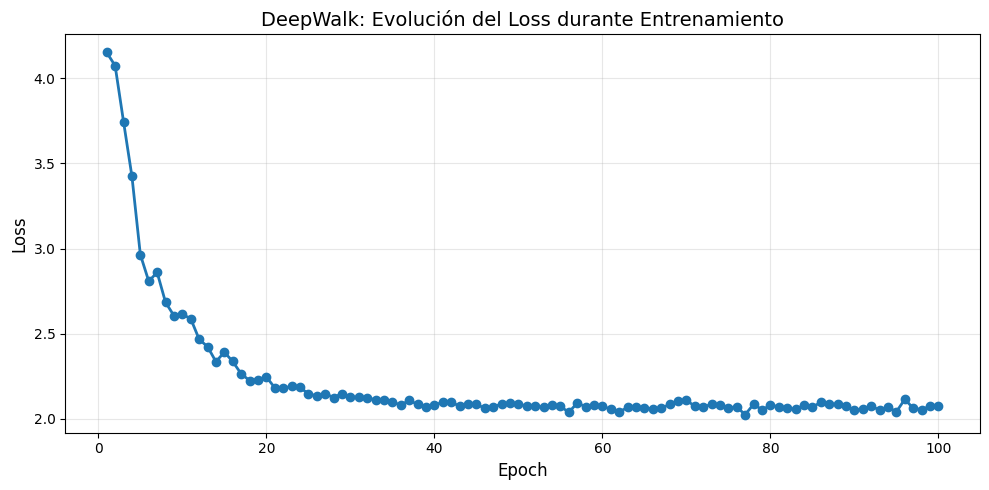

Loss inicial: 4.1523
Loss final: 2.0747
Reducción: 50.03%


In [ ]:
plot_loss_evolution(losses, NUM_EPOCHS, title='DeepWalk: Evolución del Loss durante Entrenamiento')

### Guardar Embeddings

In [82]:
# Crear directorio si no existe
import os
save_dir = DATA_PATH + 'resultados/EnfoquePorPartes/Caso5/'
os.makedirs(save_dir, exist_ok=True)

# Guardar los embeddings
embeddings_path = save_dir + f"embeddings_deepWalk_{MES}_{ANO}.pt"
torch.save(embeddings, embeddings_path)

# Guardar el modelo completo
model_path = save_dir + f"model_deepWalk_{MES}_{ANO}.pth"
torch.save(model.state_dict(), model_path)

print("=" * 60)
print("ARCHIVOS GUARDADOS")
print("=" * 60)
print(f"Embeddings guardados en: {embeddings_path}")
print(f"Modelo guardado en: {model_path}")
print(f"\nShape de embeddings guardados: {embeddings.shape}")

ARCHIVOS GUARDADOS
Embeddings guardados en: /media/valentina/KINGSTON/TESIS/data/resultados/EnfoquePorPartes/Caso5/embeddings_deepWalk_febrero_2024.pt
Modelo guardado en: /media/valentina/KINGSTON/TESIS/data/resultados/EnfoquePorPartes/Caso5/model_deepWalk_febrero_2024.pth

Shape de embeddings guardados: torch.Size([42164, 32])
